## Introduction to Data Science - Term Project


In [0]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns 
import statsmodels.api as sm 
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
import missingno as msno
import random
from sklearn.impute import SimpleImputer
import statsmodels.imputation.mice as mice
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
import time

np.set_printoptions(precision=2)
pd.set_option('precision', 2)
np.random.seed(709)
#pd.options.mode.chained_assignment = None  # disables "SettingWithCopyWarning" which appears even when code is right
print("Last Run:", time.ctime())

Last Run: Tue Jun  9 15:03:23 2020


In this study, our purpose is to predict SalePrice with a regression model given the conditions of each questions and parts.

In [0]:
df_1 = pd.read_csv("housing_data.csv")
df_1.drop(columns="Id", inplace = True)
df_1.head(5)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


# Question 1



In [0]:
my_dfs = dict() #will store all dataframes produced.
my_dfs["df_1"] = df_1.copy()

## General information about the dataframe

In [0]:
df_1.shape

(1338, 74)

- There are 1338 rows and 74 attributes (Id excluded). 

In [0]:
df_1.isnull().values.any()

False

- There is no missing values in this dataframe.

There are two attributes automatically misidentified as float64. We correct them below.

In [0]:
for attribute in df_1:
    if df_1[attribute].dtype=="float64":
        df_1[attribute] = df_1[attribute].astype("int64")

If  housing_data_description is checked , it can be seen that "MsSubClass" , "OverallQual" and "OverallCond" attributes are actually categorical attributes but they were represented as numerical. Below, we correct this miscoding.

In [0]:
convert_to_categoric = ['MSSubClass', 'OverallQual', 'OverallCond']
for categoric_attribute in convert_to_categoric:
    df_1[categoric_attribute] = df_1[categoric_attribute].astype(object)

In [0]:
# df_1.info() #shows the list of all attributes with their types

There are 41  categorical and 33 numerical variables.

### Categorical Attributes

In [0]:
ordinal_attributes = ['Street', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual','OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'CentralAir', 'KitchenQual', 'GarageFinish', 'GarageQual', 'GarageCond','PavedDrive']
#"functional" attribute is also ordinal but assumed nominal since no info given to differentiate Min1-Min2 and Max1-Max2
#similarly there are several other attributes that could be considered as ordinal if we had more info(like HouseStyle("SFoyer"?), BsmtFinType("Rec"?) )
nominal_attributes = [ x for x in df_1.select_dtypes(include = ["object"]).columns if x not in ordinal_attributes]
print("There are {} categorical attributes:".format(len(ordinal_attributes)+len(nominal_attributes)))
print("\t\t- {} ordinal categorical attributes".format(len(ordinal_attributes)))
print("\t\t- {} nominal categorical attributes".format(len(nominal_attributes)))

There are 41 categorical attributes:
		- 18 ordinal categorical attributes
		- 23 nominal categorical attributes


#### Creating a reference encoding dictionary for Ordinal Categorical Attributes

In [0]:
ordinal_categories = [
    ['Grvl', 'Pave'], # Street (using the info: Gravel is a whole lot cheaper than a concrete, asphalt, or other paved surface.)
    ["IR3", "IR2", "IR1", "Reg"], # LotShape
    ["ELO", "NoSeWa", "NoSewr", "AllPub"], # Utilities
    ["Sev", "Mod", "Gtl"], # LandSlope
    [0,1,2,3,4,5,6,7,8,9,10], # OverallQual (already encoded but rewritten for clarity)
    [0,1,2,3,4,5,6,7,8,9,10], # OverallCond (already encoded but rewritten for clarity)
    ["Po", "Fa", "TA", "Gd", "Ex"], # ExterQual
    ["Po", "Fa", "TA", "Gd", "Ex"], # ExterCond
    ["Po", "Fa", "TA", "Gd", "Ex"], # BsmtQual
    ["Po", "Fa", "TA", "Gd", "Ex"], # BsmtCond
    ["No", "Mn", "Av", "Gd"], # BsmtExposure
    ["Po", "Fa", "TA", "Gd", "Ex"], # HeatingQC
    ['N', 'Y'], # CentralAir (we considered ordinal as Altan Hoca considered in Lecture 10 codes)
    ["Po", "Fa", "TA", "Gd", "Ex"], # KitchenQual
    ["Unf", "RFn", "Fin"], # GarageFinish
    ["Po", "Fa", "TA", "Gd", "Ex"], # GarageQual
    ["Po", "Fa", "TA", "Gd", "Ex"], # GarageCond
    ["N", "P", "Y"] # PavedDrive
]
ordinal_categories_dict = dictionary = dict(zip(ordinal_attributes, ordinal_categories))
ordinal_categories_dict

{'Street': ['Grvl', 'Pave'],
 'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
 'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
 'LandSlope': ['Sev', 'Mod', 'Gtl'],
 'OverallQual': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'OverallCond': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtExposure': ['No', 'Mn', 'Av', 'Gd'],
 'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'CentralAir': ['N', 'Y'],
 'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'GarageFinish': ['Unf', 'RFn', 'Fin'],
 'GarageQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'GarageCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'PavedDrive': ['N', 'P', 'Y']}

#### Creating reference encoding dictionaries for Nominal Categorical Attributes

Here, just like we did in Ordinal Encoding part, we can enter labels manually (LabelEncoder classes_ can be adjusted as we wish). However, we get labels automatically from the data by fitting. Our assumption is that data rows take all possible values of that attribute. 

As an example, MS Zoning has 8 possible labels according to "housing_data_description.txt", however we will only fitting to 5 labels shown below since our data includes just these labels. This is no problem as long as we do not test our model on another data.

In [0]:
nominals_label_encoders_dict = dict()
for attr in nominal_attributes:
    nominals_label_encoders_dict[attr] = LabelEncoder()
    nominals_label_encoders_dict[attr].fit(df_1[attr])
nominals_label_encoders_dict["MSZoning"].classes_ #as an example

array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object)

In [0]:
nominals_onehot_encoders_dict = dict()
for attr in nominal_attributes:
    nominals_onehot_encoders_dict[attr] = OneHotEncoder(drop='first', sparse=False)
    nominals_onehot_encoders_dict[attr].fit(df_1[[attr]])
nominals_onehot_encoders_dict["Neighborhood"].categories_ #as an example

[array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
        'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
        'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
        'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
        'Veenker'], dtype=object)]

In [0]:
#Outlier Detection for Numerical Attributes
def print_outliers(data):
    for column in data.columns:
        if column=="Id":
            continue
        quantiles=data[column].quantile(q=[0.25,0.50,0.75]).values
        q1=quantiles[0]
        q2=quantiles[1]
        q3=quantiles[2]
        iqr=q3-q1
        outliers=data[(data[column] < q1-1.5*iqr ) | (data[column] >  q3+ 1.5*iqr)][column]
        print("number of outliers in {:10s} :\t{}\t({:.2%})".format(column, len(outliers), len(outliers)/len(data[column])))

### Numerical Attributes

In [0]:
numerical_attributes = list(df_1.select_dtypes(include = ["int64"]).columns)
numerical_attributes.remove("SalePrice") #SalePrice becomes the first member of the list for easy visual analysis of the dataframe
numerical_attributes = ["SalePrice"] + numerical_attributes

#### Outlier analysis

In [0]:
print_outliers(df_1[numerical_attributes])

number of outliers in SalePrice  :	56	(4.19%)
number of outliers in LotArea    :	76	(5.68%)
number of outliers in YearBuilt  :	7	(0.52%)
number of outliers in YearRemodAdd :	0	(0.00%)
number of outliers in MasVnrArea :	82	(6.13%)
number of outliers in BsmtFinSF1 :	6	(0.45%)
number of outliers in BsmtFinSF2 :	162	(12.11%)
number of outliers in BsmtUnfSF  :	29	(2.17%)
number of outliers in TotalBsmtSF :	20	(1.49%)
number of outliers in 1stFlrSF   :	17	(1.27%)
number of outliers in 2ndFlrSF   :	2	(0.15%)
number of outliers in LowQualFinSF :	18	(1.35%)
number of outliers in GrLivArea  :	29	(2.17%)
number of outliers in BsmtFullBath :	0	(0.00%)
number of outliers in BsmtHalfBath :	80	(5.98%)
number of outliers in FullBath   :	0	(0.00%)
number of outliers in HalfBath   :	0	(0.00%)
number of outliers in BedroomAbvGr :	28	(2.09%)
number of outliers in KitchenAbvGr :	39	(2.91%)
number of outliers in TotRmsAbvGrd :	27	(2.02%)
number of outliers in Fireplaces :	5	(0.37%)
number of outliers in Gar

We have decided to keep outliers in our data. We can observe if this decision negatively affects the results and change our decision if necessary.

#### SalePrice target attribute analysis 

In [0]:
df_1.SalePrice.describe()

count      1338.00
mean     186761.78
std       78913.85
min       35311.00
25%      135000.00
50%      168500.00
75%      220000.00
max      755000.00
Name: SalePrice, dtype: float64

In [0]:
def graphical_analysis(data,column_name, size1, size2):
    figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(size1, size2))
    chart = sns.distplot(data[column_name], ax=axes[0,0])
    chart.set_title('Histogram')
    for item in chart.get_xticklabels():
        item.set_rotation(45)
        item.horizontalalignment='right'
    chart = sns.boxplot(data[column_name], ax=axes[0,1])
    chart.set_title('Box Plot')
    for item in chart.get_xticklabels():
        item.set_rotation(45)
        item.horizontalalignment='right'
    chart = sns.violinplot(data[column_name], ax=axes[1,0])
    chart.set_title('Violin Plot')
    for item in chart.get_xticklabels():
        item.set_rotation(45)
        item.horizontalalignment='right'
    sm.qqplot(data[column_name], line="s", ax=axes[1,1])   
    plt.title("Q-Q plot")    
    figure.tight_layout()

number of outliers in SalePrice  :	56	(4.19%)


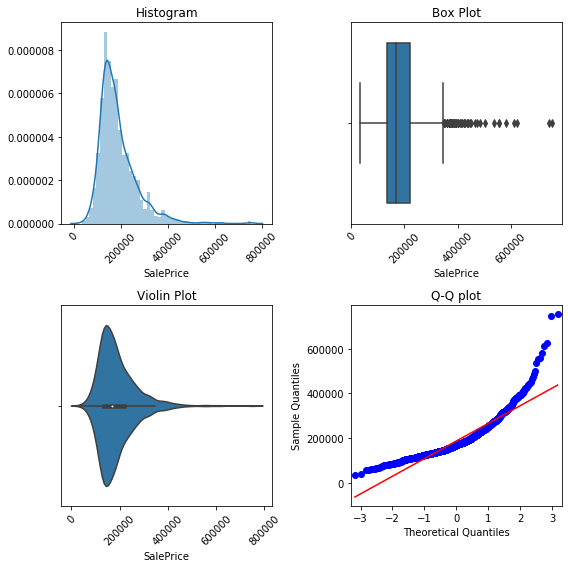

In [0]:
print_outliers(df_1[['SalePrice']])
graphical_analysis(df_1, 'SalePrice', 8,8)  

Sale price is right-skewed. It is in [35311 , 755000] range with mean=186762 and median=168500. As expected, median<mean since it is right-skewed.According to QQplot, it is not normally distributed. It has 56 outliers.

## Train and Test Set Splits

Train/Test split ratio is important for underfitting and overfitting. Less training data will result in underfitting since our model would not find chance to develop/fit. On the other hand, more training data would result in memorization of data (i.e. overfitting and as a result, generalizability could be lost. To get a balance between both, we choose a typical train/test ratio: **70/30**.

In [0]:
df_1_train, df_1_test= train_test_split(df_1, test_size = 0.3, random_state = 709)
df_1_train.reset_index(drop=True, inplace=True)
df_1_test.reset_index(drop=True, inplace=True)
l_full, l_train, l_test = len(df_1), len(df_1_train), len(df_1_test)
print(l_full, "instances in the full set")
print("\t",l_train, "instances in the training set")
print("\t",l_test, "instances in the test set")
print("Test set percentage: {:.2%}".format(l_test/l_full))

1338 instances in the full set
	 936 instances in the training set
	 402 instances in the test set
Test set percentage: 30.04%


## Introduction of major variables and naming convention for the rest of the project

Our **major dataframes** and naming convention for easily interpreting their names are as follows:

- **df_1_train** -> *df_1* is splitted to *train* and test. This includes train portion with 74 attributes. This is raw data (with no target transformation or encoding)


- **df_1_train_74_le** -> *df_1* is splitted to *train* and test. 74 attributes in the train portion is preprocessed (encoding + target transformation). Column number will keep as 74 due to *label encoding* of nominal attributes.
- **df_1_train_74_ohe** -> *df_1* is splitted to *train* and test. 74 attributes in the train portion is preprocessed (encoding + target transformation). Column number will be much higher than 74 due to *one hot encoding* of nominal attributes.


- **df_1_train_16_le** -> a subset of *df_1_train_74_lb* . Weak attributes are discarded. 
- **df_1_train_16_ohe** -> a subset of *df_1_train_74_ohe* . Weak attributes are discarded. 


- **df_1_train_6_le** -> a subset of *df_1_train_16_lb* . Only model attributes are included.
- **df_1_train_6_ohe** -> a subset of *df_1_train_16_ohe* . Only model attributes are included.

In addition to the dataframes mentioned above, we have **major auxilary variables** which are created earlier.
- *ordinal_categories_dict, nominals_label_encoders_dict, nominals_onehot_encoders_dict* -> set of reference encoders for encoding. These help us encoding the data consistently throughout the project.
- *numerical_attributes, ordinal_attributes, nominal_attributes* ->  74 total attribute names in the original data are splitted into three lists according to their category.

This naming convention will hopefully help us getting a bug-free, easily maintinable code. We wish that the rest of the project is easy to follow.

## Preprocessing

Our preprocessing stages include various tests and plots. We summarize these stages below.


### Preprocessing algorithm (Summary)

We analyze three parts(numerical, ordinal, nominal) of the dataframe *df_1_train* and by suitably encoding/transforming them we produce four temporary dataframes (these dataframes will be deleted at the end of the preprocessing): *numerical_data, ordinal_encoded_data, nominal_label_encoded_data, nominal_onehot_encoded_data* Then, by concatenating corresponding combinations of these outputs, we produce two dataframes for future use:

- **df_1_train_74_le** (as a result of df_1_train -> df_1_train_74_le)
- **df_1_train_74_ohe** (as a result of df_1_train -> df_1_train_74_ohe)

In the  **Eliminating weak attributes by feature selection** part of preprocessing, we focus on pruning data. There are 74 attributes and many of them are the same for almost all rows (like Street). We eliminate these weak attributes and decide on 16 attributes to be used in the rest of the work. 

- **df_1_train_16_le** (as a result of df_1_train_74_le -> df_1_train_16_le)
- **df_1_train_16_ohe** (as a result of df_1_train_74_ohe -> df_1_train_16_ohe)

Finally, we desing the **function preprocessor** that can be used in the later part of this study. preprocessor will be able to take raw data (like *df_1_train*) and produce the preprocessed output (like *df_1_train_16_ohe*)

### Preprocessing the Target Attribute(SalePrice)

We aim to get more "Gaussian-like" target variable by applying a transformation before regression. We tested various transformations(Log, sqrt and power transformations like yeo johnson and box box). sqrt gave poor results and others gave similar outputs. We chose log since it is easier to interpret and robust(yeo johnson gave Runtime Warnings in later steps).

In [0]:
y_raw = df_1_train[['SalePrice']]
y_log = np.log10(y_raw)
print("Test Statistic - P value for logarithmic transformation")
print("Raw target variable:\t\t\t", stats.kstest(y_raw, cdf="norm"))
print("Log Transformed target variable:\t", stats.kstest(y_log, cdf="norm"))

Test Statistic - P value for logarithmic transformation
Raw target variable:			 KstestResult(statistic=1.0, pvalue=0.0)
Log Transformed target variable:	 KstestResult(statistic=0.9999999978491853, pvalue=0.0)


According to Kolmogorov-Smirnov normality test results, in terms of being "Gaussian-like", we see slight improvement. The improvement is better observed in QQplot.

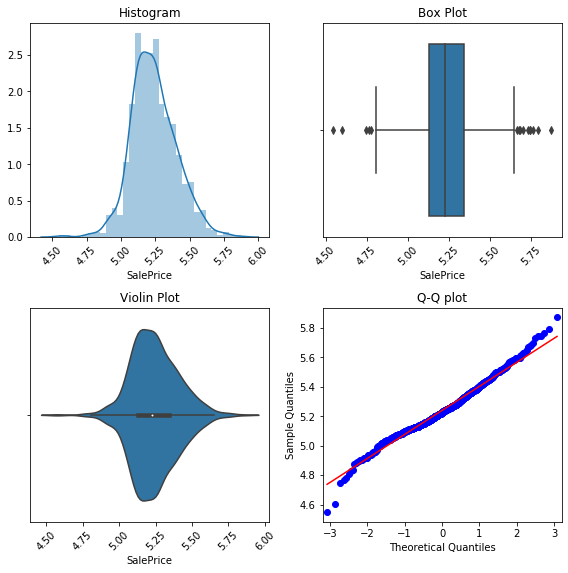

In [0]:
graphical_analysis(y_log, 'SalePrice', 8,8) 

Now, SalePrice is no more right-skewed as before. It is still not normally distributed as seen at the edges of QQplot, however it is more Gaussian-like when compared to the raw format. Moreover, we observe that log transformations decreases the number of outliers from 56 to 15.

In [0]:
print_outliers(y_log)

number of outliers in SalePrice  :	15	(1.60%)


As part of our preprocessing step, we apply log transformation to the SalePrice in our data frame.

In [0]:
numerical_data = df_1_train[numerical_attributes].copy()
numerical_data.SalePrice = y_log.copy()
print(numerical_data.shape)
numerical_data = numerical_data[ ["SalePrice"]+[x for x in numerical_data.columns if x!="SalePrice"] ] 
#display SalePrice at the left most column

(936, 33)


### About scaling

#### Standard scaling the attributes

Scaling the attributes helps us in regression analysis. By the help of scaling, we can appreciate the contribution of each attribute to the model by looking at it's coefficient. We will use standard scaling. However, we will apply scaling just before regression analysis since standard scaling results in floating point numbers which makes the processing times get longer. Moreover, creating missing data, splitting data set, applying missing data methods change the mean and standard deviation of the data. This is why applying scaling just before regression is more meaningful.

- Scaling the target attribute is possible (but we need to inverse_transform using the same scaler) but not necessary(the goal in scaling is to get interpretable coefficients - SalePrice is not a predictor). 
- Scaling numerical attributes are optional. If we were using other regressions than Ordinary Least Squares, scaling numerical attributes was a must. We will scale them since we like to get interpretable regression coefficients.
- Scaling ordinal attributes is possible although it should be taken with a grain of salt. Intervals in ordinals are not the same in fact. We will scale them since we like to get interpretable regression coefficients.
- Scaling one hot encoding is tricky. At first, it looks appealing. However, if there are few 1's in it, to adjust the std.dev, 1's can be converted to large numbers like 20! Thus, it should be avoided. As far as the interpretability of regression coefficients are concerned, their mean will be between [0,1] and intercept of regression would take this little affect(we hope). We will not scale one hot encodings.

In [0]:
def std_scaler(data):
    output = data.copy()
    attributes_to_be_scaled=[x for x in data.columns if ((x in ordinal_attributes) or (x in numerical_attributes and x!="SalePrice"))]
    output[attributes_to_be_scaled] = pd.DataFrame(StandardScaler().fit_transform(output[attributes_to_be_scaled]), columns=attributes_to_be_scaled, index = data.index)
    return output

### Preprocessing the Ordinal Categorical Attributes

#### Encoding the ordinal attributes

In [0]:
print("Ordinal attributes before encoding")
df_1_train[ordinal_attributes]

Ordinal attributes before encoding


,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,PavedDrive
0,Pave,Reg,AllPub,Gtl,4,7,TA,TA,Gd,TA,No,TA,Y,Gd,Unf,TA,TA,Y
1,Pave,Reg,AllPub,Gtl,5,4,TA,TA,TA,TA,No,Gd,Y,TA,Unf,TA,TA,Y
2,Pave,Reg,AllPub,Gtl,6,7,TA,Gd,TA,Gd,Mn,Ex,Y,Fa,Fin,TA,TA,N
3,Pave,Reg,AllPub,Gtl,7,6,TA,TA,Fa,TA,No,Gd,Y,TA,Unf,Fa,TA,Y
4,Pave,Reg,AllPub,Gtl,5,3,TA,TA,Gd,TA,No,TA,Y,TA,Unf,TA,TA,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,Pave,Reg,AllPub,Gtl,8,5,Gd,TA,Gd,TA,Av,Gd,Y,Gd,Fin,TA,TA,Y
932,Pave,IR3,AllPub,Gtl,7,5,Gd,TA,Ex,Gd,No,Ex,Y,Gd,RFn,TA,TA,Y
933,Pave,IR1,AllPub,Gtl,5,5,TA,TA,Gd,TA,No,Ex,Y,TA,RFn,TA,TA,N
934,Pave,Reg,AllPub,Gtl,6,4,TA,TA,TA,TA,Mn,TA,Y,Fa,Unf,Fa,TA,N


In [0]:
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
ordinal_encoded_data = pd.DataFrame(ordinal_encoder.fit_transform(df_1_train[ordinal_attributes]), columns=ordinal_attributes)
print("Ordinal attributes after encoding")
ordinal_encoded_data

Ordinal attributes after encoding


,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,PavedDrive
0,1.0,3.0,3.0,2.0,4.0,7.0,2.0,2.0,3.0,2.0,0.0,2.0,1.0,3.0,0.0,2.0,2.0,2.0
1,1.0,3.0,3.0,2.0,5.0,4.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,2.0,0.0,2.0,2.0,2.0
2,1.0,3.0,3.0,2.0,6.0,7.0,2.0,3.0,2.0,3.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,0.0
3,1.0,3.0,3.0,2.0,7.0,6.0,2.0,2.0,1.0,2.0,0.0,3.0,1.0,2.0,0.0,1.0,2.0,2.0
4,1.0,3.0,3.0,2.0,5.0,3.0,2.0,2.0,3.0,2.0,0.0,2.0,1.0,2.0,0.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,1.0,3.0,3.0,2.0,8.0,5.0,3.0,2.0,3.0,2.0,2.0,3.0,1.0,3.0,2.0,2.0,2.0,2.0
932,1.0,0.0,3.0,2.0,7.0,5.0,3.0,2.0,4.0,3.0,0.0,4.0,1.0,3.0,1.0,2.0,2.0,2.0
933,1.0,2.0,3.0,2.0,5.0,5.0,2.0,2.0,3.0,2.0,0.0,4.0,1.0,2.0,1.0,2.0,2.0,0.0
934,1.0,3.0,3.0,2.0,6.0,4.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,0.0


### Preprocessing the Nominal Categorical Attributes

#### Label encoding the nominal attributes (for mutual_regression in feature selection part)

In [0]:
print("Nominal attributes before label encoding")
df_1_train[nominal_attributes]

Nominal attributes before label encoding


,MSSubClass,MSZoning,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,...,MasVnrType,Foundation,BsmtFinType1,BsmtFinType2,Heating,Electrical,Functional,GarageType,SaleType,SaleCondition
0,20,RL,Lvl,Inside,Sawyer,Norm,Norm,1Fam,1Story,Gable,...,None,CBlock,BLQ,Unf,GasA,SBrkr,Min2,Attchd,WD,Normal
1,50,RL,Lvl,Inside,Edwards,Norm,Norm,1Fam,1.5Fin,Gable,...,None,CBlock,LwQ,Unf,GasA,SBrkr,Min2,Attchd,WD,Normal
2,30,RL,Lvl,Inside,BrkSide,RRAn,Norm,1Fam,1Story,Gable,...,None,BrkTil,Rec,ALQ,GasA,SBrkr,Typ,Detchd,WD,Normal
3,70,RL,Lvl,Inside,Crawfor,Norm,Norm,1Fam,2Story,Gable,...,None,BrkTil,LwQ,Unf,GasA,SBrkr,Typ,Detchd,WD,Normal
4,160,RM,Lvl,Inside,MeadowV,Norm,Norm,TwnhsE,2Story,Gable,...,None,CBlock,Rec,BLQ,GasA,SBrkr,Typ,Attchd,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,20,RL,Lvl,Corner,NridgHt,Norm,Norm,1Fam,1Story,Hip,...,BrkFace,PConc,Unf,Unf,GasA,SBrkr,Typ,Attchd,New,Partial
932,60,RL,HLS,CulDSac,Gilbert,Norm,Norm,1Fam,2Story,Gable,...,None,PConc,Unf,Unf,GasA,SBrkr,Typ,BuiltIn,New,Partial
933,90,RL,Lvl,Inside,Sawyer,Feedr,RRAe,Duplex,1.5Fin,Shed,...,None,CBlock,GLQ,Rec,GasA,SBrkr,Typ,BuiltIn,WD,Normal
934,70,RM,Lvl,Inside,OldTown,Norm,Norm,1Fam,2Story,Gable,...,None,BrkTil,Unf,Unf,GasW,SBrkr,Typ,Detchd,WD,Normal


In [0]:
print("Nominal attributes after label encoding")
nominal_label_encoded_data = pd.DataFrame()
for att in nominal_attributes:
    nominal_label_encoded_data[att] = nominals_label_encoders_dict[att].transform(df_1_train[att])
nominal_label_encoded_data

Nominal attributes after label encoding


,MSSubClass,MSZoning,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,...,MasVnrType,Foundation,BsmtFinType1,BsmtFinType2,Heating,Electrical,Functional,GarageType,SaleType,SaleCondition
0,0,3,3,4,19,2,2,0,2,1,...,2,1,1,5,0,4,3,1,8,4
1,4,3,3,4,7,2,2,0,0,1,...,2,1,3,5,0,4,3,1,8,4
2,1,3,3,4,3,6,2,0,2,1,...,2,0,4,0,0,4,6,5,8,4
3,6,3,3,4,6,2,2,0,5,1,...,2,0,3,5,0,4,6,5,8,4
4,12,4,3,4,10,2,2,4,5,1,...,2,1,4,1,0,4,6,1,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,0,3,3,0,16,2,2,0,2,3,...,1,2,5,5,0,4,6,1,6,5
932,5,3,1,1,8,2,2,0,5,1,...,2,2,5,5,0,4,6,3,6,5
933,10,3,3,4,19,1,5,2,0,5,...,2,1,2,4,0,4,6,3,8,4
934,6,4,3,4,17,2,2,0,5,1,...,2,0,5,5,1,4,6,5,8,4


In [0]:
print("Nominal attributes after onehot encoding")
nominal_onehot_encoded_data = pd.DataFrame()
for att in nominal_attributes:
    feat_names = list(nominals_onehot_encoders_dict[att].get_feature_names([att])) #naming starts with "att"
    onehot_encodings = pd.DataFrame(nominals_onehot_encoders_dict[att].transform(df_1_train[[att]]), columns=feat_names)
    nominal_onehot_encoded_data = pd.concat([nominal_onehot_encoded_data,  onehot_encodings], axis=1)
nominal_onehot_encoded_data

Nominal attributes after onehot encoding


,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
932,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
934,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


#### Concatenating the different type of attributes

In [0]:
#All attributes preprocessed and with labeled nominals
df_1_train_74_lb = pd.concat([numerical_data, ordinal_encoded_data, nominal_label_encoded_data], axis=1)
print("df_1_train_74_lb includes {} columns". format(df_1_train_74_lb.shape[1]))
df_1_train_74_ohe = pd.concat([numerical_data, ordinal_encoded_data, nominal_onehot_encoded_data], axis=1)
print("df_1_train_74_ohe includes {} columns". format(df_1_train_74_ohe.shape[1]))

#deleting the data frames we will not need anymore
del numerical_data, ordinal_encoded_data, nominal_label_encoded_data, nominal_onehot_encoded_data

df_1_train_74_lb includes 74 columns
df_1_train_74_ohe includes 214 columns


### Eliminating weak attributes by feature selection

In [0]:
def correlation_map(data, method):
    corr = data.corr(method) #kaynak ekleyebiliriz buraya
    ix = corr.sort_values('SalePrice', ascending=False).index
    df_sorted_by_correlation = data.loc[:, ix]
    # take only the first 15 highest/more correlated variables
    fifteen_more_correlated = df_sorted_by_correlation.iloc[:, :15]
    corr = fifteen_more_correlated.corr(method)[::-1]
    plt.subplots(figsize=(14,7))
    with sns.axes_style("white"):
        # display a correlation heatmap
        ax = sns.heatmap(corr, annot=True)
    plt.show()
        
def SelectKBestCustomized(data, k, score_func, target="SalePrice"):
    X=data.drop(columns=target)
    y=data[target]
    np.random.seed(709) # for mutual_info regression
    fs = SelectKBest(score_func=score_func, k=k)
    fs.fit(X, y)
    mask = fs.get_support()
    selected_features = [feature for bool, feature in zip(mask, X.columns) if bool]
    return selected_features

#### Learning about the most important numerical features by Pearson correlation analysis

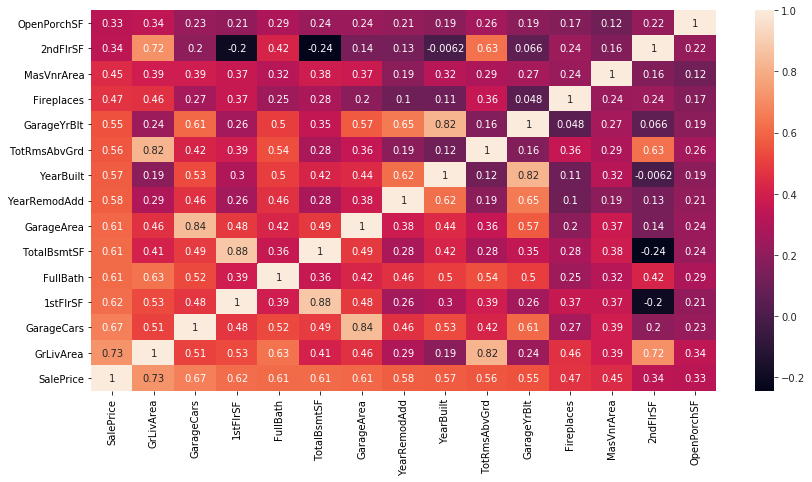

In [0]:
correlation_map(df_1_train_74_ohe[numerical_attributes], method="pearson")

- According to Pearson correlation analysis; GrLivArea(0.73), GarageCars, 1stFlrSF, FullBath, TotalBsmtSF and GarageArea are most related attributes with SalePrice.
- Note that GarageCars and GarageArea are highly correlated (0.84) as expected since GarageArea is roughly GarageCars times CarSize. Similarly, TotalBsmtSF and 1stFlrSF are highly correlated (0.88) since basement and first floor are generally very close except for a pyramid or so. Feature selection analysis will give us better idea but it looks like only one member of these pairs would be useful for our regression model.
- Most importantly, we observe that there are many weakly correlated attributes. **These weak attributes may not contribute much to our model and moreover, may slow down our data processing. Also, they may increase the model complexity and this may leads to overfitting.**

#### Learning about the most important ordinal features by Spearman correlation analysis

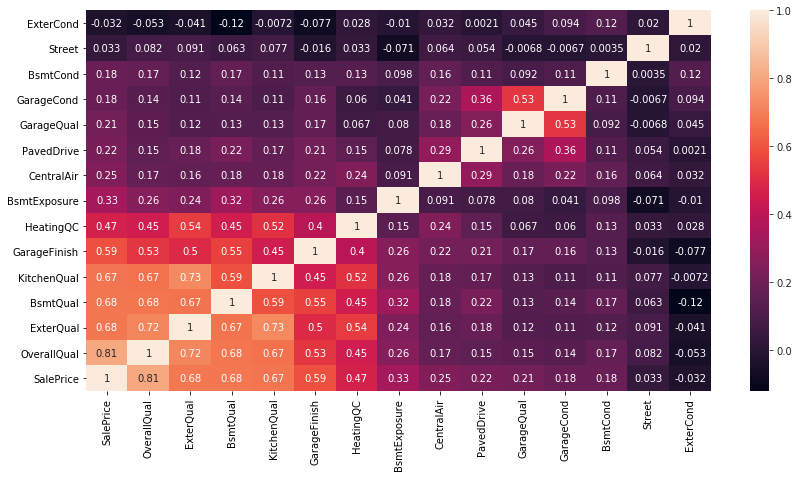

In [0]:
correlation_map(df_1_train_74_ohe[ordinal_attributes+["SalePrice"]], method="spearman")
#Spearman test can be used for the ordinal-continuous correlation analysis. 

- "OverallQual" has highest Spearman correlation with SalePrice. 
- Following are "ExterQual", "BsmtQual", and "KitchenQual".
- As the colors elegantly indicate, after "BsmtExposure" correlations weakens. **These weak attributes may not contribute much to our model and moreover, may slow down our data processing. Also, they may increase the model complexity and this may leads to overfitting.**

#### Clearing out the weak attributes by "Mutual Info Regression"method

As part of learning the data, we have identified some important features among numerical and ordinal attributes. However, we have to use different correlation methods and thus, their results are not comparable. Moreover, we could not analyzed the nominal attributes since correlation analysis is based on substracting mean etc. and these do not exist for label encoding.

We have observed that there are some weak attributes among numerical and ordinal data. When we analyze the nominal data, we also see some weak attributes. As an example, "Street" attribute is quite unnecessary since it includes only six rows of "Grvl" and the rest is "Pave".

We need a method which analyzes **all type of attributes together at once** and chooses the attributes that we can use in later steps. This way, we will be able to get rid of irrelevant/unhelpful attributes. 

As suggested in scikit website(https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html),  "Mutual Info Regression" seems suitable for this purpose. It is based on nonparametric parameters and can work with categorical features as well as other attributes. This paper (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0087357) explains its details.

In [0]:
k = 15
print("mutual_info_regression chooses these {} attributes out of all 73(numerical,ordinal,nominal,SalePrice excluded) attributes:".format(k))
mutual_info_selection = SelectKBestCustomized(data=df_1_train_74_lb, k=k, score_func=mutual_info_regression)
for attribute in mutual_info_selection:
    print(attribute,"->", end="\t")
    if attribute in numerical_attributes: print("numeric")
    elif attribute in ordinal_attributes: print("ordinal")
    elif attribute in nominal_attributes: print("nominal")

mutual_info_regression chooses these 15 attributes out of all 73(numerical,ordinal,nominal,SalePrice excluded) attributes:
YearBuilt ->	numeric
YearRemodAdd ->	numeric
TotalBsmtSF ->	numeric
1stFlrSF ->	numeric
GrLivArea ->	numeric
FullBath ->	numeric
GarageYrBlt ->	numeric
GarageCars ->	numeric
GarageArea ->	numeric
OverallQual ->	ordinal
ExterQual ->	ordinal
BsmtQual ->	ordinal
KitchenQual ->	ordinal
MSSubClass ->	nominal
Neighborhood ->	nominal


To increase the processing performance and focusing on the most important attributes, we continue our analysis with only these 15 attributes: *'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'OverallQual', 'ExterQual', 'BsmtQual', 'KitchenQual', 'MSSubClass', 'Neighborhood'*

In [0]:
subset_of_columns_ohe_included = [] #column names corresponding to the categorical nominal attributes
for x in df_1_train_74_ohe:
    for y in mutual_info_selection:
        if x.startswith(y):
            subset_of_columns_ohe_included.append(x)
df_1_train_16_ohe = df_1_train_74_ohe[["SalePrice"]+subset_of_columns_ohe_included]
print("df_1_train_16_ohe includes {} columns". format(df_1_train_16_ohe.shape[1]))
df_1_train_16_lb = df_1_train_74_lb[["SalePrice"]+mutual_info_selection]
print("df_1_train_16_lb includes {} columns". format(df_1_train_16_lb.shape[1]))

df_1_train_16_ohe includes 52 columns
df_1_train_16_lb includes 16 columns


#### Creating *preprocess* function

We end up preprocessing by creating a function that can directly give the data frame above (df_1_pp_15) when received df_1. Later, we will use this function frequently.

In [0]:
def preprocess(data):
    """
    This function takes a raw dataframe,
    (1) Clears out the unnecessary columns and decreases the attributes from 74 to 16(15 predictors+1target).
    (2)log transforms the target attribute, 
    (2)keeps the numerical attributes the same, 
    (3)ordinal encodes the ordinal attributes, and 
    (4)onehot encodes the nominal attributes (this increases the number of columns to 51). 
    *** Function keeps the np.nan values and ignores them while analyzing each column.
    The function returns the preprocessed data frame with 51 columns
    """
    output = data[df_1_train_16_lb.columns].copy() #slice 16 attributes
    for att in output: #for each attribute
        if att == "SalePrice":
            output["SalePrice"] = np.log10(output["SalePrice"])
        elif att in ordinal_attributes:
            bool_not_nans = output[att].notnull()
            col_i = output.loc[ bool_not_nans, [att] ].copy() #column of interest            
            ordinal_encoder = OrdinalEncoder(categories=[ordinal_categories_dict[att]])
            output.loc[ bool_not_nans, [att] ] = ordinal_encoder.fit_transform(col_i)
        elif att in nominal_attributes: #No NaN will appear among nominals according to Question text.
            feat_names = list(nominals_onehot_encoders_dict[att].get_feature_names([att])) #naming starts with feat names like "Neighborhood_Blmngtn"
            onehot_encodings = pd.DataFrame(nominals_onehot_encoders_dict[att].transform(output[[att]]), columns=feat_names)
            output = pd.concat([output,  onehot_encodings], axis=1)
            output = output.drop(columns=[att])
    return output

print("preprocess can make this operation: df_1_train(raw data) -> preprocessed data (as below)")
preprocess(df_1_train)

preprocess can make this operation: df_1_train(raw data) -> preprocessed data (as below)


,SalePrice,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,GarageYrBlt,GarageCars,GarageArea,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,5.11,1950,1995,1067,1067,1067,2,1996,2,436,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5.12,1949,2008,768,1148,1716,1,1949,1,281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.11,1918,2000,816,838,838,1,1961,1,275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.30,1920,1950,793,901,1802,1,1920,1,216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.93,1976,1976,536,536,1112,1,1976,1,336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,5.60,2006,2006,1935,1973,1973,2,2006,3,895,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
932,5.44,2006,2006,868,887,2021,2,2006,2,422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
933,5.28,1977,1977,1361,1361,2620,2,1977,2,600,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
934,5.07,1880,1950,1008,1178,2210,2,1930,1,205,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
def fitted_regression_model(data, model):
    data = std_scaler(data)
    X = data.drop(columns="SalePrice")
    y = data["SalePrice"]
    if model=="scikit_OLS_model": #scikit - good at producing model
        model = LinearRegression()
        model.fit(X,y)
        return model, model.score(X,y)
    elif model=="statsmodels_OLS":#statsmodels - good at producing results
        X=sm.add_constant(X)
        model = sm.OLS(endog=y, exog=X)
        results = model.fit()
        return results, results.rsquared     

## Setting up the regression model: 

### Selecting the model features

We start by creating the necessary functions.

In [0]:
std_scaler(df_1_train_74_ohe)

,SalePrice,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.11,-0.10,-0.76,0.46,-0.6,-0.05,-0.28,0.08,-0.08,-3.03e-01,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,5.12,0.09,-0.79,1.09,-0.6,-0.39,-0.28,-0.26,-0.86,-8.11e-02,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,5.11,-0.03,-1.83,0.70,-0.6,-0.58,3.67,-1.34,-0.73,-9.30e-01,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,5.30,-0.31,-1.76,-1.74,-0.6,-0.26,-0.28,-0.34,-0.79,-7.57e-01,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4.93,-0.84,0.11,-0.47,-0.6,-0.77,1.23,-0.94,-1.47,-1.76e+00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,5.60,0.39,1.12,1.00,1.4,-1.06,-0.28,3.06,2.20,2.18e+00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
932,5.44,1.35,1.12,1.00,-0.6,-1.06,-0.28,0.63,-0.60,-7.96e-01,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
933,5.28,0.89,0.15,-0.42,-0.6,0.08,1.09,0.14,0.69,5.02e-01,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
934,5.07,-0.07,-3.10,-1.74,-0.6,-1.06,-0.28,0.95,-0.23,1.04e-03,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


To start with, we apply regression to get our initial result on the preprocessed original dataset.

In [0]:
print("Number of columns in the data frame:", df_1_train_74_ohe.shape[1])
results, R2 = fitted_regression_model(df_1_train_74_ohe, model="statsmodels_OLS")
print("R2 Score (All attributes): {:.1%}".format(R2) )

Number of columns in the data frame: 214
R2 Score (All attributes): 94.3%


The coefficient of determination (R2) gives us some insight about the strength of the regression relationship. If we use all attributes in the original dataset we would end up with 94.3%. This is almost the maximum score we can get since adding more term never decreases R2 (if the new attributes are totally uncorreletaed, their coefficients get zero, and R2 is not affected). R2 is high but now our data frame is huge (213 columns).

On the other hand, as we expected, our 16 attributes give close R2 results with less columns:

In [0]:
print("Number of columns in the data frame:", df_1_train_16_ohe.shape[1])
model, R2 = fitted_regression_model(df_1_train_16_ohe, model="scikit_OLS_model")
print("R2 Score (All attributes): {:.1%}".format(R2) )

Number of columns in the data frame: 52
R2 Score (All attributes): 87.6%


We observe that **87.6% of the total variation in SalePrice can be explained by our 16 attributes** (52 columns since 2 of 16 attributes are one hot encoded).

Although this result is promising, we reach it by using 52 columns! This brings the risk of **multicollinearity**. *Multicollinearity* phenomenon occurs when an attribute is a linear combination of others. This implies that not all of the columns are contributing the regression model and they are unnecessary. For example, two different attributes may be explaning the same portion of the total variance. Keeping them in the model would decrease the processing performance in terms of memory and time requirements.

Multicollineariy also damages the explainability of regression coefficients. As a very simple example, a+b=2 can be satisfied with a=1 and b=1 as well as with a=-100, b=102. In other words, we may end up with misleading coefficients and implications such as "as the OverallQual increases SalePrice decreases".

*One way to assess multicollinearity is to compute the condition number. Values over 20 are worrisome*
"https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html#Condition-number

To check multicollinearity, we refer to condition number of the results.

In [0]:
results, R2 = fitted_regression_model(df_1_train_16_ohe, model="statsmodels_OLS")
print("Condition number(>20 indicates 'multicollinearity'):",results.condition_number)
#results.summary() #detailed results with condition_number at the bottom

Condition number(>20 indicates 'multicollinearity'): 131.99550037308057


Condition number is over 20, we conclude that we need to clear out some more attributes.

#### L1-based feature selection
Univariate feature selection methods (like f_regression, mutual_info_regression) are quite helpful but they analyze each attribute with respect to target seperately like "GarageArea"vs"SalePrice" or "FullBath"vs"SalePrice". 

To see how our attributes behave when they are together in a regression model, we use L1-based feature selection (Lasso regression). (https://scikit-learn.org/stable/modules/feature_selection.html)

Lasso regression will be used for this purpose as explained in scikit webpage. 

**alpha** is the penalization hyperparameter. alpha=0 means standard(ordinary least square based) regression. We tuned alpha and choose it such that we can identify 4-5 most important features

In [0]:
df_1_train_16_ohe

,SalePrice,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,GarageYrBlt,GarageCars,GarageArea,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,5.11,1950,1995,1067,1067,1067,2,1996,2,436,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5.12,1949,2008,768,1148,1716,1,1949,1,281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.11,1918,2000,816,838,838,1,1961,1,275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.30,1920,1950,793,901,1802,1,1920,1,216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.93,1976,1976,536,536,1112,1,1976,1,336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,5.60,2006,2006,1935,1973,1973,2,2006,3,895,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
932,5.44,2006,2006,868,887,2021,2,2006,2,422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
933,5.28,1977,1977,1361,1361,2620,2,1977,2,600,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
934,5.07,1880,1950,1008,1178,2210,2,1930,1,205,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


R2 Score (Lasso with 16 attributes): 65.6%
Lasso regression coefficients in descending order


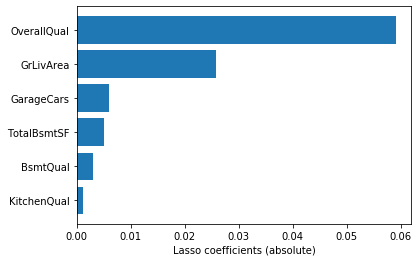

In [0]:
data = std_scaler(df_1_train_16_ohe)
X = data.drop(columns="SalePrice")
y = data["SalePrice"]
lasso_model = Lasso(alpha = 0.05)
lasso_model.fit(X,y)
print("R2 Score (Lasso with 16 attributes): {:.1%}".format( lasso_model.score(X,y) ))
print("Lasso regression coefficients in descending order")
l = [x for x in sorted(list(zip(df_1_train_16_ohe.columns[1:], lasso_model.coef_)), key = lambda x: -abs(x[1])) if abs(x[1])!=0]
names,values =zip(*l)
plt.barh(names[:10][::-1],list(map(abs,values[:10][::-1])))
plt.xlabel('Lasso coefficients (absolute)')
plt.show()

- We observe that 'OverallQual' and 'GrLivArea' are very important attributes. We have to include them in our model.
- Note that Lasso underestimates nominal attributes due to one hot encoding; we will handle categorical feature selection with a univariate analysis(mutual_info_regression)
- To choose features out of candidates highlighted by Lasso, we plot a scatter matrix.

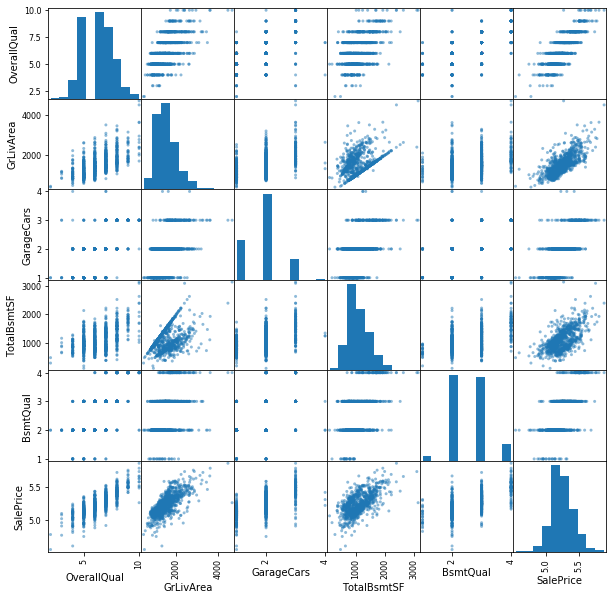

In [0]:
candidate_features = list(names[:5])
scatter_matrix(df_1_train_16_ohe[candidate_features + ["SalePrice"]] , figsize = (10, 10));

- It is like a line is inserted into the scatter plot of GrLivArea and TotalBsmtSF. We cannot understand this line. It may be an indicator of disguised data. We choose discarding 'TotalBsmtSF'. 
- In addition to 'OverallQual', 'GrLivArea', we chose 'GarageCars' and 'BsmtQual' in our model.

- Unfortunately, since nominal variables are split into one-hot columns, in a way, they are underrepresented in Lasso analysis. We will handle this problem now.

#### Revisiting "Mutual Info Regression" method

In [0]:
SelectKBestCustomized(data=df_1_train_74_lb, k=2, score_func=mutual_info_regression)

['OverallQual', 'Neighborhood']

- This *univariate* analysis indicates that out of all 73 attributes, ['Neighborhood', 'OverallQual'] are the two mostly attribute in terms of mutual information with SalePrice.
- By changing the k parameter above, we observe that the other candidate nominal attribute MSSubClass joins in the list only when k gets 15. Thus, we do not add them among our model attributes.

#### Forward Selection analysis for  'Neighborhood'
We like to keep 'Neighborhood' in our model; however, we can not claim that the variance it explains is different from the other attributes based on a univariate method. Thus, we apply simple "Forward Selection" to see if 'Neighborhood' helps to the model.

In [0]:
x = ['OverallQual', 'GrLivArea', 'GarageCars', 'BsmtQual'] #already chosen attributes
model, R2 = fitted_regression_model(df_1_train_16_ohe[x + ["SalePrice"]], model="scikit_OLS_model")
print("R2 Score with {}: {:.1%}".format(x, R2) )

R2 Score with ['OverallQual', 'GrLivArea', 'GarageCars', 'BsmtQual']: 79.0%


In [0]:
neighborhood_columns = [x for x in df_1_train_16_ohe.columns if x.startswith("Neighborhood")]
results, R2 = fitted_regression_model(df_1_train_16_ohe[x+neighborhood_columns+["SalePrice"]], model="statsmodels_OLS")
print("R2 Score with {} AND Neighborhood: {:.1%}".format(x, R2) )

R2 Score with ['OverallQual', 'GrLivArea', 'GarageCars', 'BsmtQual'] AND Neighborhood: 84.0%


The coefficient of determination (R2) clearly indicated that 'Neighborhood' increases the performance (from R2 of 79.0% to 84.0%). Now we can claim that 'Neighborhood' provides additonal contribution to our model and it would be good teammate for our other attributes.

In [0]:
print("Number of columns in the data frame:", len(x+neighborhood_columns)+1)
print("Condition number(>20 indicates 'multicollinearity'):",results.condition_number)

Number of columns in the data frame: 29
Condition number(>20 indicates 'multicollinearity'): 71.47740390151988


Now we decreased columns from 52 to 29 and now we decreased multicollinearity(cond.no). Meanwhile, the coefficient of determination (R2) decreased slightly from around 88% to 84%. We managed compressing our model by half keeping R2 almost the same. As a result of our analysis, we would like to continue our study with these five attributes:

*'OverallQual', 'Neighborhood', 'GrLivArea', 'GarageCars', 'BsmtQual'*

In [0]:
model_attributes_selection = ['OverallQual', 'Neighborhood', 'GrLivArea', 'GarageCars', 'BsmtQual']

In [0]:
subset_of_columns_ohe_included = [] #column names corresponding to the categorical nominal attributes
for x in df_1_train_16_ohe:
    for y in model_attributes_selection:
        if x.startswith(y):
            subset_of_columns_ohe_included.append(x)
df_1_train_6_ohe = df_1_train_16_ohe[["SalePrice"]+subset_of_columns_ohe_included]
print("df_1_train_6_ohe includes {} columns". format(df_1_train_6_ohe.shape[1]))
df_1_train_6_lb = df_1_train_16_lb[["SalePrice"]+model_attributes_selection]
print("df_1_train_6_lb includes {} columns". format(df_1_train_6_lb.shape[1]))
df_1_train_16_lb=df_1_train_16_lb[list(df_1_train_6_lb.columns)+[x for x in df_1_train_16_lb.columns if x not in df_1_train_6_lb.columns]] #6 attributes appears at the left of df_1_train_16_lb (for visual purposes)

df_1_train_6_ohe includes 29 columns
df_1_train_6_lb includes 6 columns


### Analyzing the selected model features

The five selected attributes:
- **Neighborhood** ->	nominal : It is an expected predictor since physical location of a building determines crime rates, school/hospital and recreational features. Mutual_info results indicate it as one of the top related attribute with OverallQual.
- **OverallQual** ->	ordinal : This was also highlighted by spearman correlation analysis as the best predictor among ordinal attributes. It is a meaningful attribute since it is an overall evaluation including many other attributes implicitly.
- **GrLivArea, BsmtQual, GarageCars**   ->	numerical : These were highlighted by pearson correlation analysis as among the best predictors having high correlations with the SalePrice. GrLivArea, BsmtQual(height of the basement) are the two features we frequently look when house searching in Turkey. GarageCars would be more related to American culture(they may be using it as living area. Many enterprises like Google starts off at the American garages).


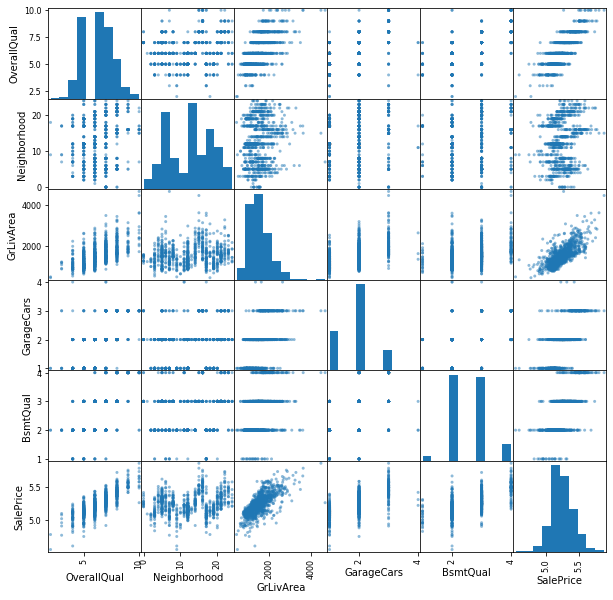

In [0]:
scatter_matrix(df_1_train_6_lb[model_attributes_selection+["SalePrice"]] , figsize = (10, 10));
#SalePrice will be shown at the last row

Looking at the scatter matrix, we obtain visual information about the distributions in the diagonal and scatter plots for pairs of attributes in the other cells. This matrix tells us how good a team work we can expect from this attributes in a regression model. Especially the last row of the plot is important for us. We can appreciate the relation between the features and the target attribute.

- SalePrice is different at different **neighborhood** of the city.
- As the **OverallQual** increase, SalePrice increase in general.
- Buidings at higher places (**BsmtQual**) have higher SalePrices in general.
- Living Area(**GrLivArea**) seems to have very strong positive correlation with SalePrice.
- As **GarageCars** increase, Saleprices increase in general.

Most importantly, we do not observe any significant nonlinear relationship which would be bad since simple regression can explain only linear relationships (while polynominial regression is more suitable for nonlinear relations)

In [0]:
print_outliers(df_1_train_6_ohe[ [x for x in model_attributes_selection if x in numerical_attributes] ])

number of outliers in GrLivArea  :	21	(2.24%)
number of outliers in GarageCars :	3	(0.32%)


We think that outliers in our selected numerical attributes are very few when compared to data size and we like to keep them in our analysis.

## Generating Missign Data Mechanism 

### Creating necessary functions

#### MCAR generator function

In [0]:
def generating_mcar(data, percent,target_columns):
    size = round((len(data)*percent))
    seed=int(percent*100)
    shuffle_data=data.copy()
    for target_column in target_columns: 
        shuffle_data = shuffle(shuffle_data, random_state=seed) 
        shuffle_data.loc[ shuffle_data.index[0]:shuffle_data.index[size-1] ,  target_column] = np.nan
        seed += 1
        print("\t MCAR with {:.2%} on '{}' is produced."
              .format(sum(shuffle_data[target_column].isnull())/len(data), target_column))
    return shuffle_data.sort_index()

#### MAR generator functions

In [0]:
def find_end_index(sort_updated_data, attribute_of_interest, ideal_index):
    length = len(sort_updated_data)
    sorted_attribute = sort_updated_data[attribute_of_interest].reset_index(drop=True)
    threshold_value = sorted_attribute.iloc[ideal_index]
    list_of_indexes = sorted_attribute[sorted_attribute==threshold_value].index
    min_index = list_of_indexes[0] # means the rule is "attribute < threshold_value"
    max_index = list_of_indexes[-1]+1 # means the rule is "attribute <= threshold_value"
    distance_to_bottom = ideal_index-min_index
    distance_to_top = max_index-ideal_index
    tolerance = 0.01
    if min(distance_to_bottom,distance_to_top) > length*tolerance:
        end_index = ideal_index
        if attribute_of_interest in numerical_attributes:
            rule = "'{}' < {} and some of {} values*".format(attribute_of_interest,threshold_value,threshold_value)
            exception =[]
            exception.append("'{}'<{} results in {:.2%} and '{}'<={} results in {:.2%}".format(attribute_of_interest,threshold_value, min_index/length,attribute_of_interest,threshold_value, max_index/length))
            exception.append("Thus, we included not all but some of {} values.".format(threshold_value))
        else:
            c = sort_updated_data[attribute_of_interest]
            included = pd.unique(c[c<threshold_value])
            rule = "'{} includes".format(attribute_of_interest)+str(included)+" and some of {} values*".format(threshold_value)
            exception =[]
            exception.append("Excluding '{}' results in {:.2%} and including it results in {:.2%}".format(threshold_value, min_index/length, max_index/length))
            exception.append("Thus, we included not all but some of {} values.".format(threshold_value))
    elif distance_to_bottom<distance_to_top:
        end_index = min_index
        if attribute_of_interest in numerical_attributes:
            rule = "'{}' < {}".format(attribute_of_interest,threshold_value)
        else:
            c = sort_updated_data[attribute_of_interest]
            included = pd.unique(c[c<threshold_value])
            rule = "'{} includes".format(attribute_of_interest)+str(included)
        exception = None
    else:
        end_index = max_index
        if attribute_of_interest in numerical_attributes:
            rule = "'{}' <= {}".format(attribute_of_interest,threshold_value)
        else:
            c = sort_updated_data[attribute_of_interest]
            included = pd.unique(c[c<=threshold_value])
            rule = "'{} includes".format(attribute_of_interest)+str(included)
        exception = None
    return rule, exception, end_index

In [0]:
def generating_mar(data, percent, target_columns, source_columns):
    size = round((len(data)*percent))
    sorted_data = data.copy()
    for source_column, target_column in zip(source_columns,target_columns): 
        sorted_data = sorted_data.sort_values(by=[source_column])
        rule, exception, size_new = find_end_index(sorted_data, source_column, size)
        sorted_data.loc[ sorted_data.index[0]:sorted_data.index[size_new-1] ,  target_column ] = np.nan
        print("\tMAR with {:.2%} on '{}' is produced with\n\t-->the rule: {}"
              .format(sum(sorted_data[ target_column ].isnull())/len(data),  target_column,rule))
        if exception!=None:
            print("\t  *Exception Details: {}".format(exception[0]))
            print("\t\t\t  {}".format(exception[1]))
    return sorted_data.sort_index()

#### MNAR generator function

In [0]:
def generating_mnar(data, percent, target_columns):
    size = round((len(data)*percent))
    sorted_data = data.copy()
    
    for target_column  in target_columns:
        
        sorted_data = sorted_data.sort_values(by=target_column)
        rule, exception, size_new = find_end_index(sorted_data, target_column, size)
        sorted_data.loc[ sorted_data.index[0]:sorted_data.index[size_new-1] ,  target_column ] = np.nan
        print("\tMNAR with {:.2%} on '{}' is produced with\n\t-->the rule: {}"
              .format(sum(sorted_data[ target_column].isnull())/len(data),  target_column,rule))
        if exception!=None:
            print("\t  *Exception Details: {}".format(exception[0]))
            print("\t\t\t  {}".format(exception[1]))     
    return sorted_data.sort_index()

#### Missing mechanism test function

Missing value visualization when used with sorting can be quite useful for missing mechanism detection purposes. We create a function for this.

In [0]:
count = 0
def miss_visualize(test_df_name):
    global count
    data = my_dfs[test_df_name]
    test_part = test_df_name[3:5] # "df_2a3" -> "2a"
    print("Testing Q{}: {}".format(test_part, detail(test_part)))
    if test_part=="2b":
        print("Data sorted with respect to {}...".format(q2_source_attr))
        data = data.sort_values(by=q2_source_attr)
    elif test_part=="2c":
        data = data.join(df_1_train_74_lb[q2_target_attr], rsuffix='(original)')
        print("Data sorted with respect to {}(original)...".format(q2_target_attr))
        data = data.sort_values(by=q2_target_attr+'(original)')
    elif test_part=="3b":
        print("Testing\ttarget attribute: {}\tsource attribute: {} MAR relation...".format(q3_target_columns[count], q3_source_columns[count]))
        print("\t---> There are 5 target-source pairs. Run this cell AGAIN to test another pair.")
        print("Data sorted with respect to {}...".format(q3_source_columns[count]))
        data = data.sort_values(by=q3_source_columns[count])
        count = (count+1)%5
    elif test_part=="3c":
        data = data.join(df_1_train_74_lb[q3_target_columns[count]], rsuffix='(original)')
        print("\t---> There are 5 target attributes. Run this cell AGAIN to test another attribute.")
        print("Data sorted with respect to {}(original)...".format(q3_target_columns[count]))
        data = data.sort_values(by=q3_target_columns[count]+'(original)')
        count = (count+1)%5
    msno.matrix(data, figsize=(15,2), sparkline=False, color=(0.5, 0.25, 0.25), fontsize=10);

def detail(part): #takes input like "2a"
    no_miss_cols = "single attribute" if part[0]=="2" else "multiple attributes"
    miss_mech = "MCAR" if part[1]=="a" else "MAR" if part[1]=="b" else "MNAR"
    return "({} on {})".format(miss_mech, no_miss_cols)

# Question 2

![q2.PNG](attachment:q2.PNG)

In [0]:
missign_percent = [0.05, 0.1, 0.25, 0.5]
q2_target_attr = "OverallQual"

### 2. a. MCAR Mechanism

![2a.PNG](attachment:2a.PNG)

In [0]:
part = "2a"
print("Creation of part", part, detail(part))
for i in range(4):
    df_name = "df"+"_"+part+str(i+1)
    print(df_name, ":")
    my_dfs[df_name]= generating_mcar(df_1_train[df_1_train_16_lb.columns], missign_percent[i], target_columns = [q2_target_attr] )

Creation of part 2a (MCAR on single attribute)
df_2a1 :
	 MCAR with 5.02% on 'OverallQual' is produced.
df_2a2 :
	 MCAR with 10.04% on 'OverallQual' is produced.
df_2a3 :
	 MCAR with 25.00% on 'OverallQual' is produced.
df_2a4 :
	 MCAR with 50.00% on 'OverallQual' is produced.


Testing Q2a: (MCAR on single attribute)


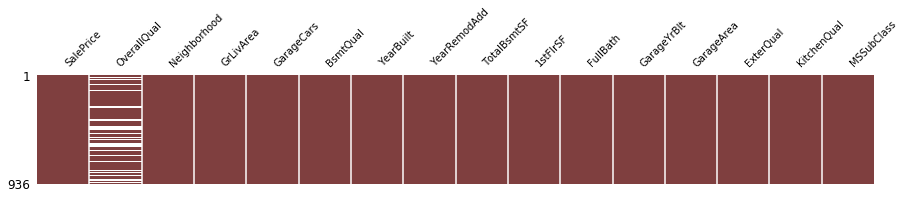

In [0]:
miss_visualize("df_2a3") # MCAR is expected

### 2. b. MAR Mechanism

![2b.PNG](attachment:2b.PNG)

#### Source attributes selection for Question 2 Part b

In [0]:
print("mutual_info_regression with target {}:".format(q2_target_attr))
SelectKBestCustomized(data=df_1_train_16_lb.drop(columns="SalePrice"), k=1, score_func=mutual_info_regression, target=q2_target_attr)

mutual_info_regression with target OverallQual:


['YearBuilt']

For MAR, we chose **YearBuilt** as our source attribute (it is highly related to OverallQual). Missing values in **OverQual** attributes may depend on the **YearBuilt** attribute because as buildings get older their overall quality decreases ant not all all people living at these buildings repair and develop their houses.

In [0]:
q2_source_attr = 'YearBuilt'

In [0]:
part = "2b"
print("Creation of part", part, detail(part))
for i in range(4):
    df_name = "df"+"_"+part+str(i+1)
    print(df_name, ":")
    my_dfs[df_name] = generating_mar(df_1_train[df_1_train_16_lb.columns], missign_percent[i], target_columns = [q2_target_attr], source_columns = [q2_source_attr])

Creation of part 2b (MAR on single attribute)
df_2b1 :
	MAR with 5.02% on 'OverallQual' is produced with
	-->the rule: 'YearBuilt' < 1920
df_2b2 :
	MAR with 10.15% on 'OverallQual' is produced with
	-->the rule: 'YearBuilt' <= 1925
df_2b3 :
	MAR with 24.68% on 'OverallQual' is produced with
	-->the rule: 'YearBuilt' < 1955
df_2b4 :
	MAR with 49.25% on 'OverallQual' is produced with
	-->the rule: 'YearBuilt' < 1976


Testing Q2b: (MAR on single attribute)
Data sorted with respect to YearBuilt...


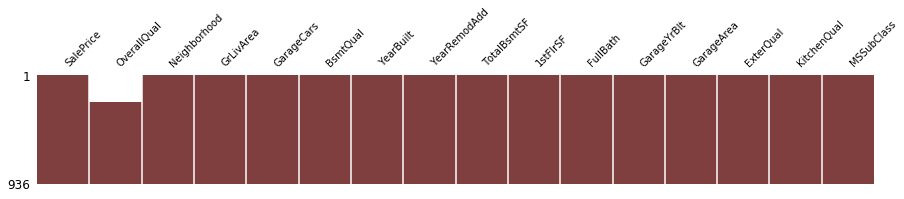

In [0]:
miss_visualize("df_2b3")
# Note: Small imperfections are normal since for some target attributes the rule was including not all but some of <= cases.

### 2. c. MNAR Mechanism

![2c.PNG](attachment:2c.PNG)

In [0]:
part = "2c"
print("Creation of part", part, detail(part))
for i in range(4):
    df_name = "df"+"_"+part+str(i+1)
    print(df_name, ":")
    my_dfs[df_name] = generating_mnar(df_1_train[df_1_train_16_lb.columns], missign_percent[i], target_columns=[q2_target_attr])

Creation of part 2c (MNAR on single attribute)
df_2c1 :
	MNAR with 5.02% on 'OverallQual' is produced with
	-->the rule: 'OverallQual includes[2 3] and some of 4 values*
	  *Exception Details: Excluding '4' results in 0.85% and including it results in 6.73%
			  Thus, we included not all but some of 4 values.
df_2c2 :
	MNAR with 10.04% on 'OverallQual' is produced with
	-->the rule: 'OverallQual includes[2 3 4] and some of 5 values*
	  *Exception Details: Excluding '5' results in 6.73% and including it results in 32.48%
			  Thus, we included not all but some of 5 values.
df_2c3 :
	MNAR with 25.00% on 'OverallQual' is produced with
	-->the rule: 'OverallQual includes[2 3 4] and some of 5 values*
	  *Exception Details: Excluding '5' results in 6.73% and including it results in 32.48%
			  Thus, we included not all but some of 5 values.
df_2c4 :
	MNAR with 50.00% on 'OverallQual' is produced with
	-->the rule: 'OverallQual includes[2 3 4 5] and some of 6 values*
	  *Exception Details: Ex

Testing Q2c: (MNAR on single attribute)
Data sorted with respect to OverallQual(original)...


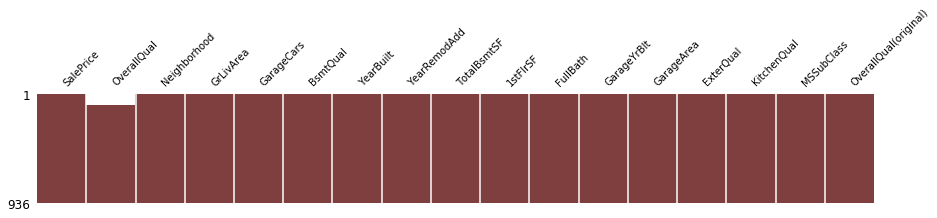

In [0]:
miss_visualize("df_2c2")
# Note: Small imperfections are normal since for some target attributes the rule was including not all but some of <= cases.

# Question 3 

![q3.PNG](attachment:q3.PNG)

#### Target attributes selection for Question 3

In our first findings report, we have chosen *'GarageArea', '1stFlrSF', 'GarageYrBlt', 'ExterQual' , 'TotRmsAbvGrd'* attributes for Question 3. Interestingly, none of these attributes are in our *selected_attributes* by coincidence.

Thus, we update three of our past *Question 3 target attributes* with three of our *selected attributes* (*'OverallQual', 'BsmtQual', 'GrLivArea'*) We like 3 out of 5 selected attributes having missing values in our model.

In [0]:
q3_target_columns = ['OverallQual', 'BsmtQual', 'GrLivArea', 'ExterQual' , 'FullBath' ]

### 3. a. MCAR Mechanism

![3a.PNG](attachment:3a.PNG)

In [0]:
part = "3a"
print("Creation of part", part, detail(part))
for i in range(4):
    df_name = "df"+"_"+part+str(i+1)
    print(df_name, ":")
    my_dfs[df_name] = generating_mcar(df_1_train[df_1_train_16_lb.columns], missign_percent[i], q3_target_columns)

Creation of part 3a (MCAR on multiple attributes)
df_3a1 :
	 MCAR with 5.02% on 'OverallQual' is produced.
	 MCAR with 5.02% on 'BsmtQual' is produced.
	 MCAR with 5.02% on 'GrLivArea' is produced.
	 MCAR with 5.02% on 'ExterQual' is produced.
	 MCAR with 5.02% on 'FullBath' is produced.
df_3a2 :
	 MCAR with 10.04% on 'OverallQual' is produced.
	 MCAR with 10.04% on 'BsmtQual' is produced.
	 MCAR with 10.04% on 'GrLivArea' is produced.
	 MCAR with 10.04% on 'ExterQual' is produced.
	 MCAR with 10.04% on 'FullBath' is produced.
df_3a3 :
	 MCAR with 25.00% on 'OverallQual' is produced.
	 MCAR with 25.00% on 'BsmtQual' is produced.
	 MCAR with 25.00% on 'GrLivArea' is produced.
	 MCAR with 25.00% on 'ExterQual' is produced.
	 MCAR with 25.00% on 'FullBath' is produced.
df_3a4 :
	 MCAR with 50.00% on 'OverallQual' is produced.
	 MCAR with 50.00% on 'BsmtQual' is produced.
	 MCAR with 50.00% on 'GrLivArea' is produced.
	 MCAR with 50.00% on 'ExterQual' is produced.
	 MCAR with 50.00% on 'Fu

Testing Q3a: (MCAR on multiple attributes)


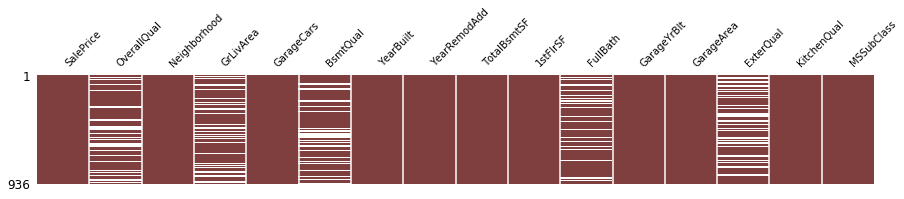

In [0]:
miss_visualize("df_3a3")

### 3. b. MAR Mechanism

![3b.PNG](attachment:3b.PNG)

#### Source attributes selection for Question 3 Part b

We chose MAR source attributes from highly related attributes.  However, we skipped some cases to avoid confusions. For example, 
if an attribute is already a target attribute and thus will have missing values, it should not be source to another target.

In [0]:
q3_source_columns = []
print("Choosing each source attribute based on its target's mutual_info_regression results:")
for i in range(5):
    target_attr = q3_target_columns[i]
    exclusion_list = list( (set(df_1_train_6_lb.columns)|set(q3_target_columns)|set(q3_source_columns)) - set([target_attr]))
    selected = SelectKBestCustomized(data=df_1_train_16_lb.drop(columns=exclusion_list), k=1, score_func=mutual_info_regression, target=target_attr)
    q3_source_columns.append(selected[0])
    print("- For target attribute '{}',\tsource attribute is chosen as '{}'.".format(q3_target_columns[i],q3_source_columns[i]))

Choosing each source attribute based on its target's mutual_info_regression results:
- For target attribute 'OverallQual',	source attribute is chosen as 'YearBuilt'.
- For target attribute 'BsmtQual',	source attribute is chosen as 'GarageYrBlt'.
- For target attribute 'GrLivArea',	source attribute is chosen as '1stFlrSF'.
- For target attribute 'ExterQual',	source attribute is chosen as 'KitchenQual'.
- For target attribute 'FullBath',	source attribute is chosen as 'YearRemodAdd'.


As shown above, 
- 'OverallQual'<--'YearBuilt'
- 'BsmtQual'<--'GarageYrBlt'
- 'GrLivArea'<--'1stFlrSF'
- 'ExterQual'<--'KitchenQual'
- 'FullBath'<--'YearRemodAdd' relations will be used for MAR.

In [0]:
part = "3b"
print("Creation of part", part, detail(part))
for i in range(4):
    df_name = "df"+"_"+part+str(i+1)
    print(df_name, ":")
    my_dfs[df_name] = generating_mar(df_1_train[df_1_train_16_lb.columns], missign_percent[i], q3_target_columns, q3_source_columns)

Creation of part 3b (MAR on multiple attributes)
df_3b1 :
	MAR with 5.02% on 'OverallQual' is produced with
	-->the rule: 'YearBuilt' < 1920
	MAR with 5.02% on 'BsmtQual' is produced with
	-->the rule: 'GarageYrBlt' < 1928
	MAR with 5.13% on 'GrLivArea' is produced with
	-->the rule: '1stFlrSF' <= 694
	MAR with 5.02% on 'ExterQual' is produced with
	-->the rule: 'KitchenQual includes[] and some of Ex values*
	  *Exception Details: Excluding 'Ex' results in 0.00% and including it results in 7.16%
			  Thus, we included not all but some of Ex values.
	MAR with 5.02% on 'FullBath' is produced with
	-->the rule: 'YearRemodAdd' < 1950 and some of 1950 values*
	  *Exception Details: 'YearRemodAdd'<1950 results in 0.00% and 'YearRemodAdd'<=1950 results in 11.65%
			  Thus, we included not all but some of 1950 values.
df_3b2 :
	MAR with 10.15% on 'OverallQual' is produced with
	-->the rule: 'YearBuilt' <= 1925
	MAR with 10.04% on 'BsmtQual' is produced with
	-->the rule: 'GarageYrBlt' < 1941
	

Testing Q3b: (MAR on multiple attributes)
Testing	target attribute: OverallQual	source attribute: YearBuilt MAR relation...
	---> There are 5 target-source pairs. Run this cell AGAIN to test another pair.
Data sorted with respect to YearBuilt...


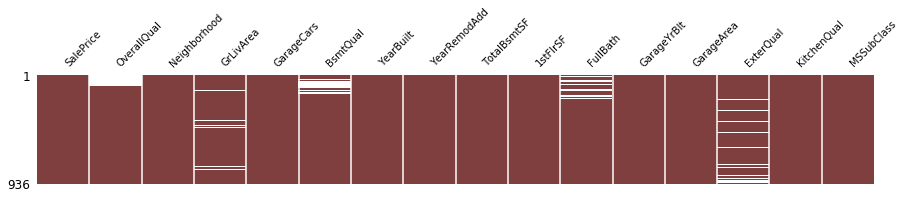

In [0]:
miss_visualize("df_3b2") # MAR is expected
# Note: Small imperfections are normal since for some target attributes the rule was including not all but some of <= cases.

### 3. c. MNAR Mechanism

![3c.PNG](attachment:3c.PNG)

In [0]:
part = "3c"
print("Creation of part", part, detail(part))
for i in range(4):
    df_name = "df"+"_"+part+str(i+1)
    print(df_name, ":")
    my_dfs[df_name] = generating_mnar(df_1_train[df_1_train_16_lb.columns], missign_percent[i], q3_target_columns)

Creation of part 3c (MNAR on multiple attributes)
df_3c1 :
	MNAR with 5.02% on 'OverallQual' is produced with
	-->the rule: 'OverallQual includes[2 3] and some of 4 values*
	  *Exception Details: Excluding '4' results in 0.85% and including it results in 6.73%
			  Thus, we included not all but some of 4 values.
	MNAR with 5.02% on 'BsmtQual' is produced with
	-->the rule: 'BsmtQual includes[] and some of Ex values*
	  *Exception Details: Excluding 'Ex' results in 0.00% and including it results in 8.87%
			  Thus, we included not all but some of Ex values.
	MNAR with 4.70% on 'GrLivArea' is produced with
	-->the rule: 'GrLivArea' < 864
	MNAR with 4.27% on 'ExterQual' is produced with
	-->the rule: 'ExterQual includes['Ex' 'Fa']
	MNAR with 5.02% on 'FullBath' is produced with
	-->the rule: 'FullBath' < 1 and some of 1 values*
	  *Exception Details: 'FullBath'<1 results in 0.64% and 'FullBath'<=1 results in 44.76%
			  Thus, we included not all but some of 1 values.
df_3c2 :
	MNAR with 1

Testing Q3c: (MNAR on multiple attributes)
	---> There are 5 target attributes. Run this cell AGAIN to test another attribute.
Data sorted with respect to BsmtQual(original)...


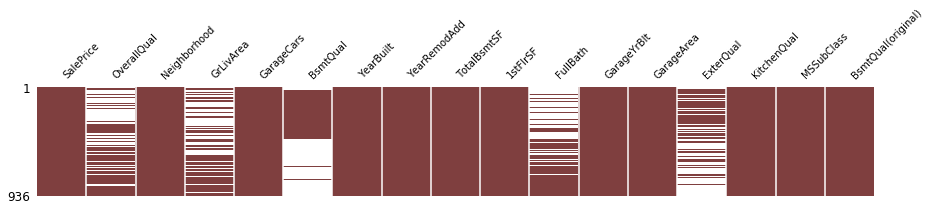

In [0]:
miss_visualize("df_3c4")
# Note: Small imperfections are normal since for some target attributes the rule was including not all but some of <= cases.

In [0]:
my_dfs["df_3c4"] #as an example of what we have now before starting to Q4.

,SalePrice,OverallQual,Neighborhood,GrLivArea,GarageCars,BsmtQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,FullBath,GarageYrBlt,GarageArea,ExterQual,KitchenQual,MSSubClass
0,128000,NaN,Sawyer,NaN,2,NaN,1950,1995,1067,1067,2.0,1996,436,NaN,Gd,20
1,131000,NaN,Edwards,1716.0,1,TA,1949,2008,768,1148,NaN,1949,281,NaN,TA,50
2,130000,6,BrkSide,NaN,1,TA,1918,2000,816,838,NaN,1961,275,TA,Fa,30
3,200100,7,Crawfor,1802.0,1,NaN,1920,1950,793,901,NaN,1920,216,TA,TA,70
4,85000,NaN,MeadowV,NaN,1,NaN,1976,1976,536,536,NaN,1976,336,TA,TA,160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,395000,8,NridgHt,1973.0,3,NaN,2006,2006,1935,1973,2.0,2006,895,NaN,Gd,20
932,274725,7,Gilbert,2021.0,2,NaN,2006,2006,868,887,2.0,2006,422,NaN,Gd,60
933,190000,NaN,Sawyer,2620.0,2,NaN,1977,1977,1361,1361,NaN,1977,600,TA,TA,90
934,117500,NaN,OldTown,2210.0,1,TA,1880,1950,1008,1178,2.0,1930,205,TA,Fa,70


# Question 4 and 5

![q_4_5.PNG](attachment:q_4_5.PNG)

#### Our proposed method

We follow the suggestion in the question test and propose: modifying MICE method such that generated dataframes are merged into a single dataframe by taking average. The resultant dataframe will be used as an alternative single imputation technique.

#### Measurement metric

We will have y_pred house prices and y_real house prices. MSE is one of the most straightforward and common methods for comparing continuous outputs like SalePrice.

Our performance metrics for regression are
- **R2** : Coefficient of determination - applied on training data - gives us some insight about the strength of the regression relationship - This metric is not available for MICE imputation because there is no single training data
- **MSE_train**: Mean Squared Error (MSE) applied on training data - shows us how close our fitting is to the training data - This metric is not available for MICE imputation because there is no single training data
- **MSE_test**: Mean Squared Error (MSE) applied on testing data - shows us how close our predictions are to the real data

In [0]:
try: my_metrics #do not overwrite if already exists
except: my_metrics = dict() #this dictionary will hold the metrics for each analysis

try: my_mice_results #do not overwrite if already exists
except: my_mice_results = dict() #mice results will be stored in this dict

### Creating the necessary functions

#### Functions for applying missing data handling methods

In [0]:
formula = "attr_SalePrice" + " ~ " + " + ".join([("attr_"+x) for x in df_1_train_6_ohe.columns if x!="SalePrice"])
print("MICE analysis will be based on this formula:\n",formula.replace("+","\n\t\t\t+").replace("~","~\t"))
#attr_ prefix is for MICEData

MICE analysis will be based on this formula:
 attr_SalePrice ~	 attr_GrLivArea 
			+ attr_GarageCars 
			+ attr_OverallQual 
			+ attr_BsmtQual 
			+ attr_Neighborhood_Blueste 
			+ attr_Neighborhood_BrDale 
			+ attr_Neighborhood_BrkSide 
			+ attr_Neighborhood_ClearCr 
			+ attr_Neighborhood_CollgCr 
			+ attr_Neighborhood_Crawfor 
			+ attr_Neighborhood_Edwards 
			+ attr_Neighborhood_Gilbert 
			+ attr_Neighborhood_IDOTRR 
			+ attr_Neighborhood_MeadowV 
			+ attr_Neighborhood_Mitchel 
			+ attr_Neighborhood_NAmes 
			+ attr_Neighborhood_NPkVill 
			+ attr_Neighborhood_NWAmes 
			+ attr_Neighborhood_NoRidge 
			+ attr_Neighborhood_NridgHt 
			+ attr_Neighborhood_OldTown 
			+ attr_Neighborhood_SWISU 
			+ attr_Neighborhood_Sawyer 
			+ attr_Neighborhood_SawyerW 
			+ attr_Neighborhood_Somerst 
			+ attr_Neighborhood_StoneBr 
			+ attr_Neighborhood_Timber 
			+ attr_Neighborhood_Veenker


In [0]:
def rows_listwise(data):
    return data.dropna()
def delete_feature(data):
    return data.drop(columns = [column for column in data.columns if data[column].isnull().any()])
def single_impute(data, method="median"): #median works also for ordinal attributes
    output = data.copy()
    col_m = [column for column in output.columns if output[column].isnull().any()] #columns with missing values
    output[col_m] = pd.DataFrame(SimpleImputer(strategy=method).fit_transform(output[col_m]), columns=col_m, index=data.index)
    return output

def multiple_impute(data, n_imputations):
    output = std_scaler(data)
    output = output.add_prefix("attr_") #MICEData requires columns d.n. start with digits
    np.random.seed(709)
    print("..",end="")
    imp = mice.MICEData(output, history_callback= history_logger )
    mice_class = mice.MICE(formula, sm.OLS, imp, n_skip=0) #### n_skip=3 by default!
    result = mice_class.fit(n_burnin=0, n_imputations = n_imputations) #### n_burnin=10 by default!
    print("\b\b",end="")
    return imp.history , result
def history_logger(x):
    output = x.data.copy()
    output.columns = [x[5:] for x in output.columns] #remove attr_ prefixes
    print("\b\b{}".format(str(len(x.history)).zfill(2)),end="")
    return output
    
def proposed_impute(data, n_imputations):
    output = std_scaler(data)
    output = output.add_prefix("attr_") #MICEData requires columns d.n. start with digits
    print("..",end="")
    np.random.seed(13)
    imp = mice.MICEData(output)
    print(end="\b\b")
    sum_df = pd.DataFrame(np.zeros(imp.data.shape), columns=imp.data.columns)
    for iter_no in range( n_imputations ):
        print(str(iter_no).zfill(2),end="") #zero fill/pad
        sum_df += imp.next_sample()
        print(end="\b\b")
    average_df  = sum_df/(n_imputations)
    average_df.columns = data.columns #remove attr_ prefixes
    return average_df

def table_missing_data_methods(part, recalculate=False):
    if recalculate==False:
        if "df_"+part+"4_pm" in my_dfs:
            print("The results already exist. This is a time consuming process. If you still like to recalculate,")
            print('run this function: table_missing_data_methods(part="{}", recalculate=True)'.format(part))
            return
    print("Question\tExplanation\t\t\t\tData frames created from", part, detail(part))
    print("\t\t\t\t\t\t\t",end="")
    for m in missign_percent:
        print("m = {:.0%}\t\t".format(m),end="")
    print("\n4.a\t\t\tDelete Missing Value")
    print("\ti.\trows-listwise",end="\t\t\t\t")
    for i in range(1,5):
        source_df_name = "df_"+part+str(i)
        target_df_name = source_df_name+"_rl"
        my_dfs[target_df_name] = rows_listwise ( preprocess(my_dfs[source_df_name]) )
        print(target_df_name,end="\t")

    print("\n\tii.\tdelete feature*", end="\t\t\t\t\t\t\t")
    source_df_name = "df_"+part+ "1"
    target_df_name = "df_"+part[0]+ "_delf"
    my_dfs[target_df_name] = delete_feature ( preprocess(my_dfs[source_df_name]) )
    print(target_df_name)

    print("4.b\t\t\tSingle(median) Imputation",end="\t")
    for i in range(1,5):
        source_df_name = "df_"+part+str(i)
        target_df_name = source_df_name+"_si"
        my_dfs[target_df_name] = single_impute ( preprocess(my_dfs[source_df_name]) )
        print(target_df_name,end="\t")

    print("\n4.c\t\t\tMultiple Imputation",end="\t\t")
    row = 1
    n_imputations = [10,20,30]
    for n in n_imputations:
        print("\n\t{}.\t\t\t{} imputation".format("i"*row,n),end="\t\t")
        for i in range(1,5):
            source_df_name = "df_{}{}".format(part,i)
            if part[1]=="c": 
                imp_data_list, result = multiple_impute ( preprocess(my_dfs[source_df_name])[df_1_train_6_ohe.columns], n )#if MNAR -> send only the five selected attributes
            else:     
                imp_data_list, result = multiple_impute ( preprocess(my_dfs[source_df_name]) , n )#if MCAR or MAR -> send all attributes
            target_df_name = "{}_mi{}".format(source_df_name, row)
            my_mice_results[target_df_name] = result
            for j in range(1,n+1):
                my_dfs[target_df_name+"_"+str(j).zfill(2)] = imp_data_list[j] #imp_data_list[0] is useless/mean imputed
            print("{}_mi{}_1-{}".format(source_df_name,row,n),end="\t")
        row+=1

    print("\n5\t\t\tOur proposed method",end="\t\t")
    for i in range(1,5):
        source_df_name = "df_"+part+str(i)
        target_df_name = source_df_name+"_pm"
        my_dfs[target_df_name] = proposed_impute ( preprocess(my_dfs[source_df_name]), n_imputations = 10)
        print(target_df_name,end="\t")
    print()
    
def check_shapes(part):
    print("Question\tExplanation\t\t\t\tDataframe shapes created from", part, detail(part))
    print("\t\t\t\t\t\t\t",end="")
    for m in missign_percent:
        print("m = {:.0%}\t\t".format(m),end="")
    print("\n4.a\t\t\tDelete Missing Value")
    print("\ti.\trows-listwise",end="\t\t\t\t")
    for i in range(1,5):
        source_df_name = "df_"+part+str(i)
        target_df_name = source_df_name+"_rl"
        print(my_dfs[target_df_name].shape,end="\t")

    print("\n\tii.\tdelete feature*", end="\t\t\t\t\t\t\t")
    source_df_name = "df_"+part+ "1"
    target_df_name = "df_"+part[0]+ "_delf"
    print(my_dfs[target_df_name].shape)

    print("4.b\t\t\tSingle(median) Imputation",end="\t")
    for i in range(1,5):
        source_df_name = "df_"+part+str(i)
        target_df_name = source_df_name+"_si"
        print(my_dfs[target_df_name].shape,end="\t")

    print("\n4.c\t\t\tMultiple Imputation",end="\t\t")
    row = 1
    n_imputations = [10,20,30]
    for n in n_imputations:
        print("\n\t{}.\t\t\t{} imputation".format("i"*row,n),end="\t\t")
        for i in range(1,5):
            source_df_name = "df_{}{}".format(part,i)
            target_df_name = "{}_mi{}".format(source_df_name, row)
            print(my_dfs[target_df_name+"_01"].shape,end="\t")
        row+=1
    print("\n5\t\t\tOur proposed method",end="\t\t")
    for i in range(1,5):
        source_df_name = "df_"+part+str(i)
        target_df_name = source_df_name+"_pm"
        print(my_dfs[target_df_name].shape,end="\t")
    print()

#### Functions for fitting regression models and making predictions

In [0]:
def calculate_regression_model_metrics(part):
    for i in range(1,5): ###############################rows-listwise
        target_df_name = "df_"+part+str(i)+"_rl"
        my_metrics[target_df_name] = fit_reg_train_test(my_dfs[target_df_name][df_1_train_6_ohe.columns])# target_df_name has 16 attributes but our model will fit on 6.
    ###############################delete feature
    target_df_name = "df_"+part[0]+ "_delf"
    model_attributes_undeleted = [x for x in df_1_train_6_ohe.columns if x in my_dfs[target_df_name].columns]
    my_metrics[target_df_name] = fit_reg_train_test(my_dfs[target_df_name][model_attributes_undeleted])
    for i in range(1,5): ###############################Single(median) Imputation
        target_df_name = "df_"+part+str(i)+"_si"
        my_metrics[target_df_name] = fit_reg_train_test(my_dfs[target_df_name][df_1_train_6_ohe.columns])
    for c in range(1,4): ###############################Multiple Imputation
        for i in range(1,5):
            target_df_name = "df_"+part+str(i)+"_mi"+str(c)
            #Slice the data/order the columns (scikit workis with arrays and requires the same order)
            model, _ = fitted_regression_model(df_1_train_6_ohe, model="scikit_OLS_model") #just to initialize
            model.intercept_ = my_mice_results[target_df_name].params[0] #coefs overwritten
            model.coef_ = np.array([my_mice_results[target_df_name].params[1:]]) #coefs overwritten
            R2 = "Not Available" #statsmodels MICE module also do not give any R2 metric for MICE...
            MSE_train = "Not Available" #...because there is no single training data - coeffs developed on many data
            """ (the validity of these are arguable for MICE since there is no single training data)
            #Apply scaling for regression
            data_train = std_scaler(df_1_train_6_ohe)
            X_train = data_train.drop(columns="SalePrice") #fit already done - just for metric calculation
            y_train = data_train["SalePrice"] #fit already done - just for metric calculation
            #Produce metrics on train 
            R2 = model.score(X_train, y_train)#always calculated on train set(without NaNs)
            y_train_pred = model.predict(X_train)
            y_train_pred = 10**y_train_pred #untransform
            y_train_true = 10**y_train #untransform
            MSE_train = mean_squared_error(y_train_true, y_train_pred)
            """
            #Get testing data - It is not preprocessed!
            data_test = preprocess(df_1_test[df_1_train_16_lb.columns])
            #Slice the data/order the columns (scikit workis with arrays and requires the same order)
            data_test = data_test[df_1_train_6_ohe.columns]
            #Apply scaling for regression
            data_test = std_scaler(data_test)
            X_test = data_test.drop(columns="SalePrice") #ready for regression predict
            y_test = df_1_test["SalePrice"] #ready for MSE
            #Predict on testing data
            y_test_pred = model.predict(X_test)
            #Produce MSE on train
            y_test_pred = 10**y_test_pred #untransform
            y_test_true = y_test #already in raw format
            MSE_test = mean_squared_error(y_test_true, y_test_pred)
            my_metrics[target_df_name] = {"R2":R2, "MSE_train":MSE_train, "MSE_test":MSE_test, "y_test_pred":y_test_pred}            
    for i in range(1,5):###############################Our proposed method
        target_df_name = "df_"+part+str(i)+"_pm"
        my_metrics[target_df_name] = fit_reg_train_test(my_dfs[target_df_name][df_1_train_6_ohe.columns])

       
def fit_reg_train_test(data_train): #data_train should contain only "to be fitted" and "already preprocessed" columns
    #Learn from the data (df_1_train_6_ohe.columns minus some column(s) if delete feature)
    available_model_attributes = [x for x in df_1_train_6_ohe.columns if x in data_train.columns] #delete feature case
    #Slice the data/order the columns (scikit workis with arrays and requires the same order)
    data_train = data_train[available_model_attributes].copy()
    #Apply scaling for regression
    data_train = std_scaler(data_train)
    X_train = data_train.drop(columns="SalePrice") #ready for regression fit and predict
    y_train = data_train["SalePrice"] #ready for regression fit
    #Fit the model on training data
    model = LinearRegression()
    model.fit(X_train,y_train)
    R2 = model.score(X_train, y_train)#always calculated on train set
    #Produce MSE on train
    y_train_pred = model.predict(X_train)
    y_train_pred = 10**y_train_pred #untransform
    y_train_true = 10**y_train #untransform
    MSE_train = mean_squared_error(y_train_true, y_train_pred)
    
    #Get testing data - It is not preprocessed!
    data_test = preprocess(df_1_test[df_1_train_16_lb.columns])
    #Slice the data/order the columns (scikit workis with arrays and requires the same order)
    data_test = data_test[available_model_attributes]
    #Apply scaling for regression
    data_test = std_scaler(data_test)
    X_test = data_test.drop(columns="SalePrice") #ready for regression predict
    y_test = df_1_test["SalePrice"] #ready for MSE
    #Predict on testing data
    y_test_pred = model.predict(X_test)
    #Produce MSE on train
    y_test_pred = 10**y_test_pred #untransform
    y_test_true = y_test #already in raw format
    MSE_test = mean_squared_error(y_test_true, y_test_pred)
    return {"R2":R2, "MSE_train":MSE_train, "MSE_test":MSE_test, "y_test_pred":y_test_pred}

def visualize_pred_test(df_name): #scatter plot
    if df_name not in my_metrics:
        print("Calculating the results first...")
        calculate_regression_model_metrics(part=df_name[3:5])
    plt.grid(color='r', linestyle='-', linewidth=2,alpha=0.1)
    plt.plot([0,800],[0,800], '--k')
    plt.xlabel("True price ($1000s)")
    plt.ylabel("Predicted price ($1000s)")
    plt.axis('tight')
    y_test_true = df_1_test["SalePrice"]
    y_test_pred = my_metrics[df_name]["y_test_pred"]
    plt.scatter(y_test_true/1000,y_test_pred/1000, alpha = 0.5)
    plt.show()

def visualize_test_MSEs(part): #sns line plot
    x_axis = ["5%","10%","25%","50%"]
    fig, ax = plt.subplots(figsize=(7,7))
    legend_list =["rows listwise","delete feature","single imputation","multiple imputation(10)","multiple imputation(20)","multiple imputation(30)","proposed method"]
    suffix_list =["rl","delf","si","mi1","mi2","mi3","pm"]
    for suffix in suffix_list:
        if suffix=="delf":
            data_name = ["df_"+part[0]+"_"+suffix]*4
        else:
            data_name = ["df_"+part+str(i)+"_"+suffix for i in range(1,5)]
        sns.lineplot(x=x_axis, 
                     y=[my_metrics[x]["MSE_test"] for x in data_name],
                     ax=ax, sort=False)
    ax.legend(legend_list, facecolor='w')
    ax.set_title("Part {} - {}\nMean Squared Error(MSE) for Test Data".format(part, detail(part)), fontsize= 12)
    plt.xlabel("Missingness Percentage (m)", fontsize= 12)
    plt.ylabel("MSE", fontsize= 12)
    plt.tight_layout()
    plt.show()
    
def metric_printer(target_df_name, metric):
    if metric=="R2":
        if "mi" in target_df_name:
            print(my_metrics[target_df_name][metric], end="\t")
        else:
            print("{:.2%}".format( my_metrics[target_df_name][metric] ),end="\t\t" )
    elif metric=="MSE_train" or metric=="MSE_test":
        if "mi" in target_df_name and metric=="MSE_train":
            print(my_metrics[target_df_name][metric], end="\t")
        else:
            print("{:.2e}".format( my_metrics[target_df_name][metric] ),end="\t" )
    elif metric=="MSE_train(log10)" or metric=="MSE_test(log10)":
        if "mi" in target_df_name and metric=="MSE_train(log10)":
            print(my_metrics[target_df_name][metric[:-7]], end="\t")
        else:
            print("{:.4f}".format( np.log10(my_metrics[target_df_name][metric[:-7]]) ),end="\t\t" )            

def table_metric(part,metric):
    if "df_"+part+"1_rl" not in my_metrics:
        print("Calculating the results first...")
        calculate_regression_model_metrics(part)
    print(metric,"results\n------------------------------------------------")
    print("Question\tExplanation\t\t\t\t Regression results for", part,detail(part))
    print("\t\t\t\t\t\t\t",end="")
    for m in missign_percent:
        print("m = {:.0%}\t\t".format(m),end="")
    print("\n4.a\t\t\tDelete Missing Value")
    print("\ti.\trows-listwise",end="\t\t\t\t")
    for i in range(1,5):
        target_df_name = "df_"+part+str(i)+"_rl"
        metric_printer(target_df_name, metric)      
    print("\n\tii.\tdelete feature*", end="\t\t\t\t\t\t\t")
    target_df_name = "df_"+part[0]+ "_delf"
    metric_printer(target_df_name, metric)
    print("\n4.b\t\t\tSingle(median) Imputation",end="\t")
    for i in range(1,5):
        target_df_name = "df_"+part+str(i)+"_si"
        metric_printer(target_df_name, metric)
    print("\n4.c\t\t\tMultiple Imputation",end="")
    for c in range(1,4):
        print("\n\t"+"i"*c+".\t"+str(c*10)+" imputation",end="\t\t\t\t")
        for i in range(1,5): ###############################(1,5)
            target_df_name = "df_"+part+str(i)+"_mi"+str(c)
            metric_printer(target_df_name, metric)
    print("\n5\t\t\tOur proposed method",end="\t\t")
    for i in range(1,5):
        target_df_name = "df_"+part+str(i)+"_pm"
        metric_printer(target_df_name, metric)
    print("\n")

#### Functions for saving and loading produced dataframes

In [0]:
"""
Note for future:
- Note that my_mice_results will not be loaded thus, you need to run the cells if you like the multiple imputation results. 
- TODO: we can save the mice_results in a suitable format and load them just like my_dfs)
"""

def load(folder_name, file_list = "All"):
    d = dict()
    print("Loading from folder: '{}'".format(folder_name))
    file_list = [x for x in os.listdir(folder_name) if x.endswith(".csv")]
    l = len(file_list)
    x=1
    for file_name in file_list:
        if (file_list == "All") or (file_name in file_list):
            d[file_name[:-4] ] = pd.read_csv(os.path.join(folder_name, file_name))
            print("\r\t{} out of {} files ({:.0%}) are loaded.".format(x, l, x/l ), end="")
            x+=1
    print()    
    return d

def save(dictionary, folder_name, file_list = "All"):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    print("Saving to folder: '{}'".format(folder_name))
    l = len(dictionary) if file_list=="All" else len(file_list)
    x=1
    for name,file in dictionary.items():
        if (file_list == "All") or (name in file_list):
            file.to_csv( os.path.join(folder_name, name+".csv"), index=False)
            print("\r\t{} out of {} files ({:.0%}) are saved.".format(x, l, x/l ), end="")
            x+=1
    print()

### Loading dataframes from a folder to save time:
- The cells including *table_missing_data_methods* below can take about half an hour for each to complete
- Instead of running them, you can load .csv from a folder by using the code below. For this purpose, uncomment the lines and run the cell.
- Note that my_mice_results will not be loaded thus, you need to run the cells if you like the multiple imputation results.

In [0]:
#%%time
#load_files_in_this_folder = "Dfs_TermProject_PinarErdogan_AlpBayar_OguzHanoglu"
# my_dfs = load(folder_name = load_files_in_this_folder)

### Tables' Analysis

#### Data frames created from 2.a

![q4_2a.PNG](attachment:q4_2a.PNG)

In [0]:
%%time
# measuring the cell execution time may give us an idea about the process and help us in debugging the code
table_missing_data_methods(part = "2a")

Question	Explanation				Data frames created from 2a (MCAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				df_2a1_rl	df_2a2_rl	df_2a3_rl	df_2a4_rl	
	ii.	delete feature*							df_2_delf
4.b			Single(median) Imputation	df_2a1_si	df_2a2_si	df_2a3_si	df_2a4_si	
4.c			Multiple Imputation		
	i.			10 imputation		df_2a1_mi1_1-10	df_2a2_mi1_1-10	df_2a3_mi1_1-10	df_2a4_mi1_1-10	
	ii.			20 imputation		df_2a1_mi2_1-20	df_2a2_mi2_1-20	df_2a3_mi2_1-20	df_2a4_mi2_1-20	
	iii.			30 imputation		df_2a1_mi3_1-30	df_2a2_mi3_1-30	df_2a3_mi3_1-30	df_2a4_mi3_1-30	
5			Our proposed method		df_2a1_pm	df_2a2_pm	df_2a3_pm	df_2a4_pm	
Wall time: 10min 11s


In [0]:
check_shapes(part="2a")

Question	Explanation				Dataframe shapes created from 2a (MCAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				(889, 52)	(842, 52)	(702, 52)	(468, 52)	
	ii.	delete feature*							(936, 51)
4.b			Single(median) Imputation	(936, 52)	(936, 52)	(936, 52)	(936, 52)	
4.c			Multiple Imputation		
	i.			10 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
	ii.			20 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
	iii.			30 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
5			Our proposed method		(936, 52)	(936, 52)	(936, 52)	(936, 52)	


- Results are as expected.
- We observe that rows decrease from 936 to 889, 842, 702, 468 for rows-listwise method.
- Delete feature decreases the column number by 1.
- Other methods do not delete anything, instead fill the missing cells.

In [0]:
calculate_regression_model_metrics("2a") #comment this if already calculated
question_part = "2a"
table_metric(part=question_part, metric="R2")
table_metric(part=question_part, metric="MSE_train") #or metric="MSE_train(log10)" can be used to see log10 values
table_metric(part=question_part, metric="MSE_test") #or metric="MSE_test(log10)" can be used to see log10 values

R2 results
------------------------------------------------
Question	Explanation				 Regression results for 2a (MCAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				85.38%		84.39%		84.39%		82.22%		
	ii.	delete feature*							80.56%		
4.b			Single(median) Imputation	84.38%		82.99%		82.53%		81.10%		
4.c			Multiple Imputation
	i.	10 imputation				Not Available	Not Available	Not Available	Not Available	
	ii.	20 imputation				Not Available	Not Available	Not Available	Not Available	
	iii.	30 imputation				Not Available	Not Available	Not Available	Not Available	
5			Our proposed method		84.75%		84.24%		84.61%		84.90%		

MSE_train results
------------------------------------------------
Question	Explanation				 Regression results for 2a (MCAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				7.76e+08	9.63e+08	1.01e+09	1.02e+09	
	ii.	delete feature*							1.16e+09	
4.b		

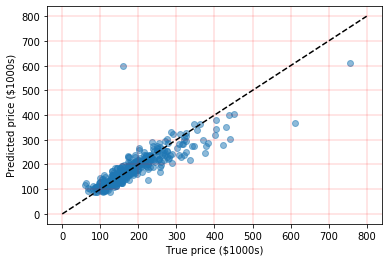

In [0]:
visualize_pred_test(df_name="df_2a4_rl")#feel free to test other df_names

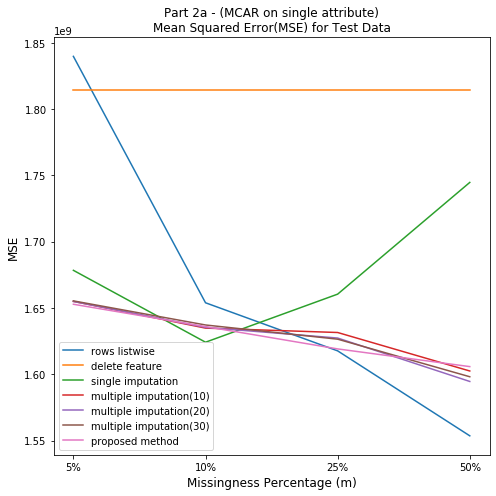

In [0]:
visualize_test_MSEs(part = "2a")

- In the graph above, in general, MSE scores decrease while the missing percentage increase for the methods. This can be seen more clear on the row-listwise method. There is an opposite situation exist for the single imputation method.

#### Data frames created from 2.b

![q4_2b.PNG](attachment:q4_2b.PNG)

In [0]:
%%time
table_missing_data_methods(part="2b")

Question	Explanation				Data frames created from 2b (MAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				df_2b1_rl	df_2b2_rl	df_2b3_rl	df_2b4_rl	
	ii.	delete feature*							df_2_delf
4.b			Single(median) Imputation	df_2b1_si	df_2b2_si	df_2b3_si	df_2b4_si	
4.c			Multiple Imputation		
	i.			10 imputation		df_2b1_mi1_1-10	df_2b2_mi1_1-10	df_2b3_mi1_1-10	df_2b4_mi1_1-10	
	ii.			20 imputation		df_2b1_mi2_1-20	df_2b2_mi2_1-20	df_2b3_mi2_1-20	df_2b4_mi2_1-20	
	iii.			30 imputation		df_2b1_mi3_1-30	df_2b2_mi3_1-30	df_2b3_mi3_1-30	df_2b4_mi3_1-30	
5			Our proposed method		df_2b1_pm	df_2b2_pm	df_2b3_pm	df_2b4_pm	
Wall time: 10min 27s


In [0]:
check_shapes(part="2b")

Question	Explanation				Dataframe shapes created from 2b (MAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				(889, 52)	(841, 52)	(705, 52)	(475, 52)	
	ii.	delete feature*							(936, 51)
4.b			Single(median) Imputation	(936, 52)	(936, 52)	(936, 52)	(936, 52)	
4.c			Multiple Imputation		
	i.			10 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
	ii.			20 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
	iii.			30 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
5			Our proposed method		(936, 52)	(936, 52)	(936, 52)	(936, 52)	


- Results are as expected.

In [0]:
calculate_regression_model_metrics("2b") #comment this if already calculated
question_part = "2b"
table_metric(part=question_part, metric="R2")
table_metric(part=question_part, metric="MSE_train") #or metric="MSE_train(log10)" can be used to see log10 values
table_metric(part=question_part, metric="MSE_test") #or metric="MSE_test(log10)" can be used to see log10 values

R2 results
------------------------------------------------
Question	Explanation				 Regression results for 2b (MAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				84.66%		84.86%		84.87%		82.03%		
	ii.	delete feature*							80.56%		
4.b			Single(median) Imputation	82.97%		82.39%		81.53%		81.21%		
4.c			Multiple Imputation
	i.	10 imputation				Not Available	Not Available	Not Available	Not Available	
	ii.	20 imputation				Not Available	Not Available	Not Available	Not Available	
	iii.	30 imputation				Not Available	Not Available	Not Available	Not Available	
5			Our proposed method		83.75%		83.52%		82.56%		82.15%		

MSE_train results
------------------------------------------------
Question	Explanation				 Regression results for 2b (MAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				9.44e+08	9.67e+08	1.04e+09	1.26e+09	
	ii.	delete feature*							1.16e+09	
4.b			S

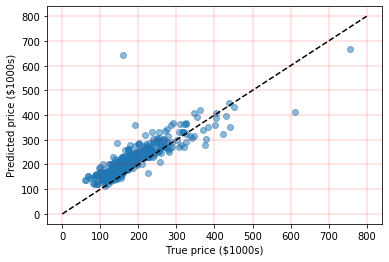

In [0]:
visualize_pred_test(df_name="df_2b4_rl")#feel free to test other df_names

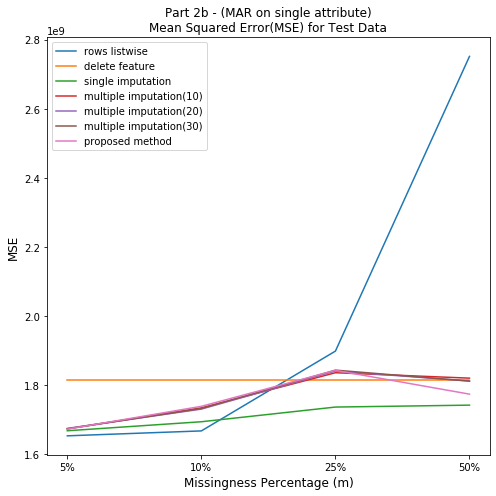

In [0]:
visualize_test_MSEs(part = "2b")

- For the rows-listwise method, while missing percentage increase, MSE scores also increase.

#### Data frames created from 2.c

![q4_2c.PNG](attachment:q4_2c.PNG)

In [0]:
%%time
table_missing_data_methods(part = "2c")

Question	Explanation				Data frames created from 2c (MNAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				df_2c1_rl	df_2c2_rl	df_2c3_rl	df_2c4_rl	
	ii.	delete feature*							df_2_delf
4.b			Single(median) Imputation	df_2c1_si	df_2c2_si	df_2c3_si	df_2c4_si	
4.c			Multiple Imputation		
	i.			10 imputation		df_2c1_mi1_1-10	df_2c2_mi1_1-10	df_2c3_mi1_1-10	df_2c4_mi1_1-10	
	ii.			20 imputation		df_2c1_mi2_1-20	df_2c2_mi2_1-20	df_2c3_mi2_1-20	df_2c4_mi2_1-20	
	iii.			30 imputation		df_2c1_mi3_1-30	df_2c2_mi3_1-30	df_2c3_mi3_1-30	df_2c4_mi3_1-30	
5			Our proposed method		df_2c1_pm	df_2c2_pm	df_2c3_pm	df_2c4_pm	
Wall time: 6min 4s


In [0]:
check_shapes(part="2c")

Question	Explanation				Dataframe shapes created from 2c (MNAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				(889, 52)	(842, 52)	(702, 52)	(468, 52)	
	ii.	delete feature*							(936, 51)
4.b			Single(median) Imputation	(936, 52)	(936, 52)	(936, 52)	(936, 52)	
4.c			Multiple Imputation		
	i.			10 imputation		(936, 29)	(936, 29)	(936, 29)	(936, 29)	
	ii.			20 imputation		(936, 29)	(936, 29)	(936, 29)	(936, 29)	
	iii.			30 imputation		(936, 29)	(936, 29)	(936, 29)	(936, 29)	
5			Our proposed method		(936, 52)	(936, 52)	(936, 52)	(936, 52)	


- Results are as expected.
- Note that multiple imputation tables have only columns belonging to 6 attributes(29) whereas that was 16 attributes(52) for MCAR and MAR parts.
- MICE forms a formula(MICEData.conditional_formula) inside itself based on the all attributes provided to it. Thus, we intentionally crop MNAR dataframes so that MICE for MNAR is based on solely model attributes. If MICE for MNAR would reach to other attributes that are highly correlated with the target attribute of missing mechanism, MICE for MNAR would be almost the same as MICE for MAR.
- As an example, 'BsmtQual' has missing data in Q4. We know that 'ExterQual' has high Spearman correlation with 'BsmtQual'. Assume that they are almost equal. During the MNAR MICE, if we provide 'ExterQual' to MICE, MICE will realize their similarity and fill 'BsmtQual' with 'ExterQual'. In a way, missingness of 'BsmtQual' depends on 'ExterQual' and MNAR assumption is violated. This is why MNAR MICE dataframes are narrower than MCAR/MAR MICE dataframes.

In [0]:
calculate_regression_model_metrics("2c") #comment this if already calculated
question_part = "2c"
table_metric(part=question_part, metric="R2")
table_metric(part=question_part, metric="MSE_train") #or metric="MSE_train(log10)" can be used to see log10 values
table_metric(part=question_part, metric="MSE_test") #or metric="MSE_test(log10)" can be used to see log10 values

R2 results
------------------------------------------------
Question	Explanation				 Regression results for 2c (MNAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				83.83%		83.43%		82.97%		81.55%		
	ii.	delete feature*							80.56%		
4.b			Single(median) Imputation	82.53%		82.28%		81.12%		81.35%		
4.c			Multiple Imputation
	i.	10 imputation				Not Available	Not Available	Not Available	Not Available	
	ii.	20 imputation				Not Available	Not Available	Not Available	Not Available	
	iii.	30 imputation				Not Available	Not Available	Not Available	Not Available	
5			Our proposed method		83.40%		83.17%		83.26%		82.69%		

MSE_train results
------------------------------------------------
Question	Explanation				 Regression results for 2c (MNAR on single attribute)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				9.73e+08	1.00e+09	1.12e+09	1.36e+09	
	ii.	delete feature*							1.16e+09	
4.b		

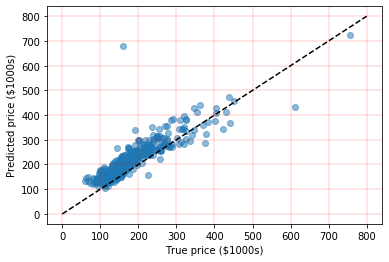

In [0]:
visualize_pred_test(df_name="df_2c4_rl")#feel free to test other df_names

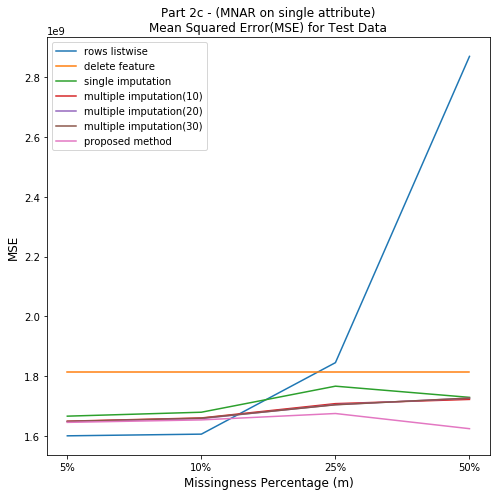

In [0]:
visualize_test_MSEs(part = "2c")

- For the rows-listwise method, while missing percentage increase, MSE scores also increase.

#### Data frames created from 3.a

![q4_3a.PNG](attachment:q4_3a.PNG)

In [0]:
%%time
table_missing_data_methods(part = "3a")

Question	Explanation				Data frames created from 3a (MCAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				df_3a1_rl	df_3a2_rl	df_3a3_rl	df_3a4_rl	
	ii.	delete feature*							df_3_delf
4.b			Single(median) Imputation	df_3a1_si	df_3a2_si	df_3a3_si	df_3a4_si	
4.c			Multiple Imputation		
	i.			10 imputation		df_3a1_mi1_1-10	df_3a2_mi1_1-10	df_3a3_mi1_1-10	df_3a4_mi1_1-10	
	ii.			20 imputation		df_3a1_mi2_1-20	df_3a2_mi2_1-20	df_3a3_mi2_1-20	df_3a4_mi2_1-20	
	iii.			30 imputation		df_3a1_mi3_1-30	df_3a2_mi3_1-30	df_3a3_mi3_1-30	df_3a4_mi3_1-30	
5			Our proposed method		df_3a1_pm	df_3a2_pm	df_3a3_pm	df_3a4_pm	
Wall time: 32min 16s


In [0]:
check_shapes(part="3a")

Question	Explanation				Dataframe shapes created from 3a (MCAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				(722, 52)	(543, 52)	(241, 52)	(31, 52)	
	ii.	delete feature*							(936, 47)
4.b			Single(median) Imputation	(936, 52)	(936, 52)	(936, 52)	(936, 52)	
4.c			Multiple Imputation		
	i.			10 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
	ii.			20 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
	iii.			30 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
5			Our proposed method		(936, 52)	(936, 52)	(936, 52)	(936, 52)	


- Results are as expected.

In [0]:
calculate_regression_model_metrics("3a") #comment this if already calculated
question_part = "3a"
table_metric(part=question_part, metric="R2")
table_metric(part=question_part, metric="MSE_train") #or metric="MSE_train(log10)" can be used to see log10 values
table_metric(part=question_part, metric="MSE_test") #or metric="MSE_test(log10)" can be used to see log10 values

R2 results
------------------------------------------------
Question	Explanation				 Regression results for 3a (MCAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				84.58%		84.32%		86.03%		94.80%		
	ii.	delete feature*							64.96%		
4.b			Single(median) Imputation	84.09%		82.35%		79.01%		72.51%		
4.c			Multiple Imputation
	i.	10 imputation				Not Available	Not Available	Not Available	Not Available	
	ii.	20 imputation				Not Available	Not Available	Not Available	Not Available	
	iii.	30 imputation				Not Available	Not Available	Not Available	Not Available	
5			Our proposed method		84.78%		84.34%		84.41%		84.92%		

MSE_train results
------------------------------------------------
Question	Explanation				 Regression results for 3a (MCAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				8.22e+08	1.07e+09	7.43e+08	2.42e+08	
	ii.	delete feature*							2.22e+09	

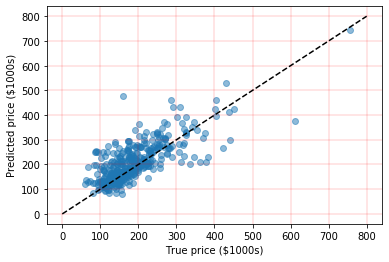

In [0]:
visualize_pred_test(df_name="df_3a4_rl")#feel free to test other df_names

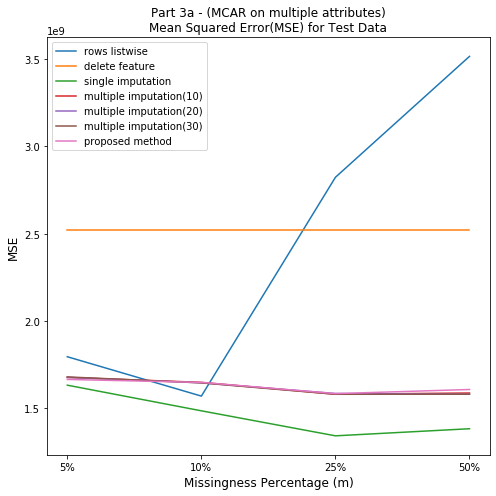

In [0]:
visualize_test_MSEs(part = "3a")

- For the rows-listwise method, there is a small decrease in MSE score while missing percent is increase from 5 to 10, then it start to increase.

#### Data frames created from 3.b

![q4_3b.PNG](attachment:q4_3b.PNG)

In [0]:
%%time
table_missing_data_methods(part = "3b")

Question	Explanation				Data frames created from 3b (MAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				df_3b1_rl	df_3b2_rl	df_3b3_rl	df_3b4_rl	
	ii.	delete feature*							df_3_delf
4.b			Single(median) Imputation	df_3b1_si	df_3b2_si	df_3b3_si	df_3b4_si	
4.c			Multiple Imputation		
	i.			10 imputation		df_3b1_mi1_1-10	df_3b2_mi1_1-10	df_3b3_mi1_1-10	df_3b4_mi1_1-10	
	ii.			20 imputation		df_3b1_mi2_1-20	df_3b2_mi2_1-20	df_3b3_mi2_1-20	df_3b4_mi2_1-20	
	iii.			30 imputation		df_3b1_mi3_1-30	df_3b2_mi3_1-30	df_3b3_mi3_1-30	df_3b4_mi3_1-30	
5			Our proposed method		df_3b1_pm	df_3b2_pm	df_3b3_pm	df_3b4_pm	
Wall time: 34min 10s


In [0]:
check_shapes(part="3b")

Question	Explanation				Dataframe shapes created from 3b (MAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				(747, 52)	(622, 52)	(268, 52)	(8, 52)	
	ii.	delete feature*							(936, 47)
4.b			Single(median) Imputation	(936, 52)	(936, 52)	(936, 52)	(936, 52)	
4.c			Multiple Imputation		
	i.			10 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
	ii.			20 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
	iii.			30 imputation		(936, 52)	(936, 52)	(936, 52)	(936, 52)	
5			Our proposed method		(936, 52)	(936, 52)	(936, 52)	(936, 52)	


- Results are as expected.

In [0]:
calculate_regression_model_metrics("3b") #comment this if already calculated
question_part = "3b"
table_metric(part=question_part, metric="R2")
table_metric(part=question_part, metric="MSE_train") #or metric="MSE_train(log10)" can be used to see log10 values
table_metric(part=question_part, metric="MSE_test") #or metric="MSE_test(log10)" can be used to see log10 values

R2 results
------------------------------------------------
Question	Explanation				 Regression results for 3b (MAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				84.07%		83.31%		80.00%		99.94%		
	ii.	delete feature*							64.96%		
4.b			Single(median) Imputation	81.30%		80.09%		76.49%		72.92%		
4.c			Multiple Imputation
	i.	10 imputation				Not Available	Not Available	Not Available	Not Available	
	ii.	20 imputation				Not Available	Not Available	Not Available	Not Available	
	iii.	30 imputation				Not Available	Not Available	Not Available	Not Available	
5			Our proposed method		83.44%		83.24%		82.08%		80.74%		

MSE_train results
------------------------------------------------
Question	Explanation				 Regression results for 3b (MAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				7.31e+08	6.29e+08	8.44e+08	5.31e+05	
	ii.	delete feature*							2.22e+09	
4

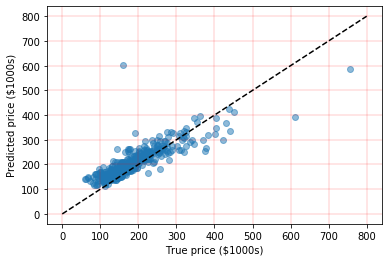

In [0]:
visualize_pred_test(df_name="df_3b3_rl")#feel free to test other df_names

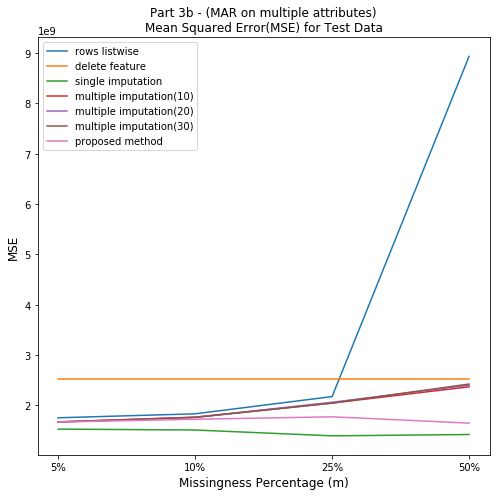

In [0]:
visualize_test_MSEs(part = "3b")

- In the graph above, it can be said that while missing data percentage increases , MSE score also increases for the rows-listwise method.

#### Data frames created from 3.c

![q4_3c.PNG](attachment:q4_3c.PNG)

In [0]:
%%time
table_missing_data_methods(part = "3c")

Question	Explanation				Data frames created from 3c (MNAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				df_3c1_rl	df_3c2_rl	df_3c3_rl	df_3c4_rl	
	ii.	delete feature*							df_3_delf
4.b			Single(median) Imputation	df_3c1_si	df_3c2_si	df_3c3_si	df_3c4_si	
4.c			Multiple Imputation		
	i.			10 imputation		df_3c1_mi1_1-10	df_3c2_mi1_1-10	df_3c3_mi1_1-10	df_3c4_mi1_1-10	
	ii.			20 imputation		df_3c1_mi2_1-20	df_3c2_mi2_1-20	df_3c3_mi2_1-20	df_3c4_mi2_1-20	
	iii.			30 imputation		df_3c1_mi3_1-30	df_3c2_mi3_1-30	df_3c3_mi3_1-30	df_3c4_mi3_1-30	
5			Our proposed method		df_3c1_pm	df_3c2_pm	df_3c3_pm	df_3c4_pm	
Wall time: 13min 18s


In [0]:
check_shapes(part="3c")

Question	Explanation				Dataframe shapes created from 3c (MNAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				(744, 52)	(573, 52)	(237, 52)	(18, 52)	
	ii.	delete feature*							(936, 47)
4.b			Single(median) Imputation	(936, 52)	(936, 52)	(936, 52)	(936, 52)	
4.c			Multiple Imputation		
	i.			10 imputation		(936, 29)	(936, 29)	(936, 29)	(936, 29)	
	ii.			20 imputation		(936, 29)	(936, 29)	(936, 29)	(936, 29)	
	iii.			30 imputation		(936, 29)	(936, 29)	(936, 29)	(936, 29)	
5			Our proposed method		(936, 52)	(936, 52)	(936, 52)	(936, 52)	


- Results are as expected.

In [0]:
calculate_regression_model_metrics("3c") #comment this if already calculated
question_part = "3c"
table_metric(part=question_part, metric="R2")
table_metric(part=question_part, metric="MSE_train") #or metric="MSE_train(log10)" can be used to see log10 values
table_metric(part=question_part, metric="MSE_test") #or metric="MSE_test(log10)" can be used to see log10 values

R2 results
------------------------------------------------
Question	Explanation				 Regression results for 3c (MNAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				81.08%		78.07%		79.00%		93.66%		
	ii.	delete feature*							64.96%		
4.b			Single(median) Imputation	80.03%		78.05%		72.77%		72.12%		
4.c			Multiple Imputation
	i.	10 imputation				Not Available	Not Available	Not Available	Not Available	
	ii.	20 imputation				Not Available	Not Available	Not Available	Not Available	
	iii.	30 imputation				Not Available	Not Available	Not Available	Not Available	
5			Our proposed method		82.86%		82.16%		81.34%		79.87%		

MSE_train results
------------------------------------------------
Question	Explanation				 Regression results for 3c (MNAR on multiple attributes)
							m = 5%		m = 10%		m = 25%		m = 50%		
4.a			Delete Missing Value
	i.	rows-listwise				6.48e+08	6.50e+08	5.46e+08	1.57e+08	
	ii.	delete feature*							2.22e+09	

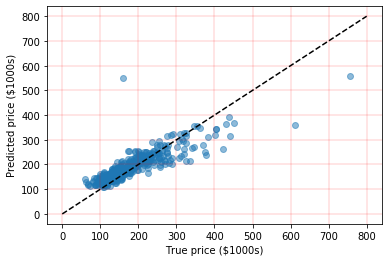

In [0]:
visualize_pred_test(df_name="df_3c3_rl")#feel free to test other df_names

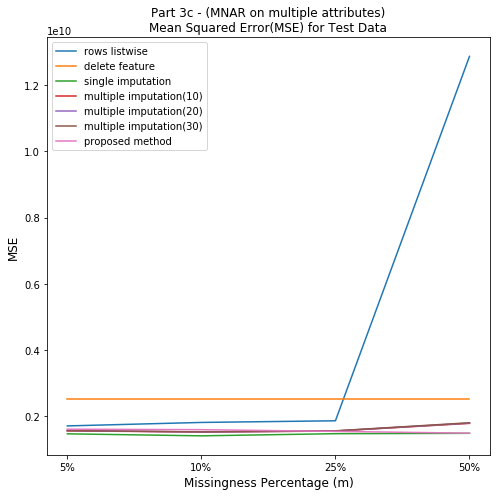

In [0]:
visualize_test_MSEs(part = "3c")

- In general, for the all the methods, MSE do not change, but for the rows-listwise method after 25% missing percentage, there is a sharp increase on MSE score.

### Overall Results

In [0]:
mean_predict = np.full_like(df_1_test["SalePrice"], np.mean(df_1_train["SalePrice"]))
MSE_for_mean_prediction = mean_squared_error(df_1_test["SalePrice"], mean_predict)
print("The MSE we would obtain if our model was just predicting mean(train) for all cases:{:.4e}".format(MSE_for_mean_prediction))

The MSE we would obtain if our model was just predicting mean(train) for all cases:6.3071e+09


The simple but one of the worst models would predict mean of y_train for all cases. This would result in MSE_test=6.3e+09.

In a way, our various models are trying to minimize this number. The fact that we have missing values increase this number but regression decreases this number.

#### Forming a summary table

In [0]:
percentage = ["5%","10%","25%","50%"]
summary_table = pd.DataFrame()
missingness = {"a":"MCAR", "b":"MAR", "c":"MNAR"}
attribute={"2":"single attribute", "3":"multiple attributes"}
legend_list =["rows listwise","delete feature","single imputation","multiple imputation(10)","multiple imputation(20)","multiple imputation(30)","proposed method"]
suffix_list =["rl","delf","si","mi1","mi2","mi3","pm"]
for part in ["2a","2b","2c","3a","3b","3c"]:
    for suffix in suffix_list:
        if suffix=="delf":
            data_names = ["df_"+part[0]+"_"+suffix]*4
        else:
            data_names = ["df_"+part+str(i)+"_"+suffix for i in range(1,5)]
        for i in range(4):
            MSE_value_test = my_metrics[data_names[i]]["MSE_test"]
            MSE_value_train = my_metrics[data_names[i]]["MSE_train"]
            MSE_value_train = np.nan if MSE_value_train=='Not Available' else MSE_value_train
            entry = pd.DataFrame({"Missingness Percentage":percentage[i], "Question #":"Question "+part[0], "Part":"Part "+part, "Missingness":detail(part)[1:][:-1], "Attribute":attribute[part[0]],  "Missingness Mechanism": missingness[part[1]] ,"Missingness Handling Method": legend_list[suffix_list.index(suffix)], "data_name":[data_names[i]], "MSE Type":"MSE on Training Data", "Mean Squared Error(MSE)": MSE_value_train})
            summary_table = summary_table.append(entry)
            entry["MSE Type"] = "MSE on Test Data"
            entry["Mean Squared Error(MSE)"] = MSE_value_test
            summary_table = summary_table.append(entry)

summary_table = summary_table.reset_index(drop=True)
print("Table includes {} entries".format(len(summary_table)))
summary_table

Table includes 336 entries


,Missingness Percentage,Question #,Part,Missingness,Attribute,Missingness Mechanism,Missingness Handling Method,data_name,MSE Type,Mean Squared Error(MSE)
0,5%,Question 2,Part 2a,MCAR on single attribute,single attribute,MCAR,rows listwise,df_2a1_rl,MSE on Training Data,7.76e+08
1,5%,Question 2,Part 2a,MCAR on single attribute,single attribute,MCAR,rows listwise,df_2a1_rl,MSE on Test Data,1.84e+09
2,10%,Question 2,Part 2a,MCAR on single attribute,single attribute,MCAR,rows listwise,df_2a2_rl,MSE on Training Data,9.63e+08
3,10%,Question 2,Part 2a,MCAR on single attribute,single attribute,MCAR,rows listwise,df_2a2_rl,MSE on Test Data,1.65e+09
4,25%,Question 2,Part 2a,MCAR on single attribute,single attribute,MCAR,rows listwise,df_2a3_rl,MSE on Training Data,1.01e+09
...,...,...,...,...,...,...,...,...,...,...
331,10%,Question 3,Part 3c,MNAR on multiple attributes,multiple attributes,MNAR,proposed method,df_3c2_pm,MSE on Test Data,1.60e+09
332,25%,Question 3,Part 3c,MNAR on multiple attributes,multiple attributes,MNAR,proposed method,df_3c3_pm,MSE on Training Data,1.03e+09
333,25%,Question 3,Part 3c,MNAR on multiple attributes,multiple attributes,MNAR,proposed method,df_3c3_pm,MSE on Test Data,1.54e+09
334,50%,Question 3,Part 3c,MNAR on multiple attributes,multiple attributes,MNAR,proposed method,df_3c4_pm,MSE on Training Data,1.12e+09


#### Train and Test MSEs for all data set

Train and Test MSEs for data sets in Part 2a


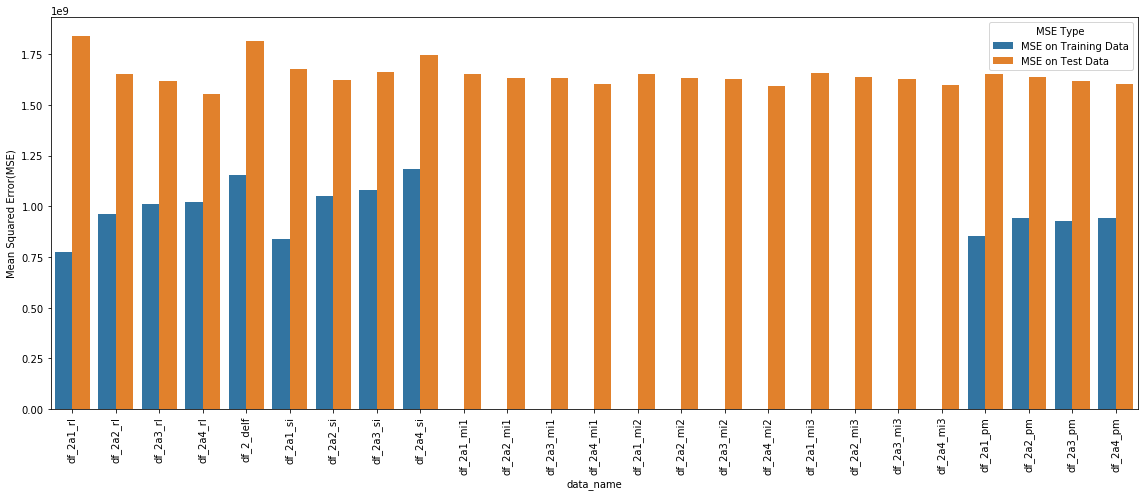

Train and Test MSEs for data sets in Part 2b


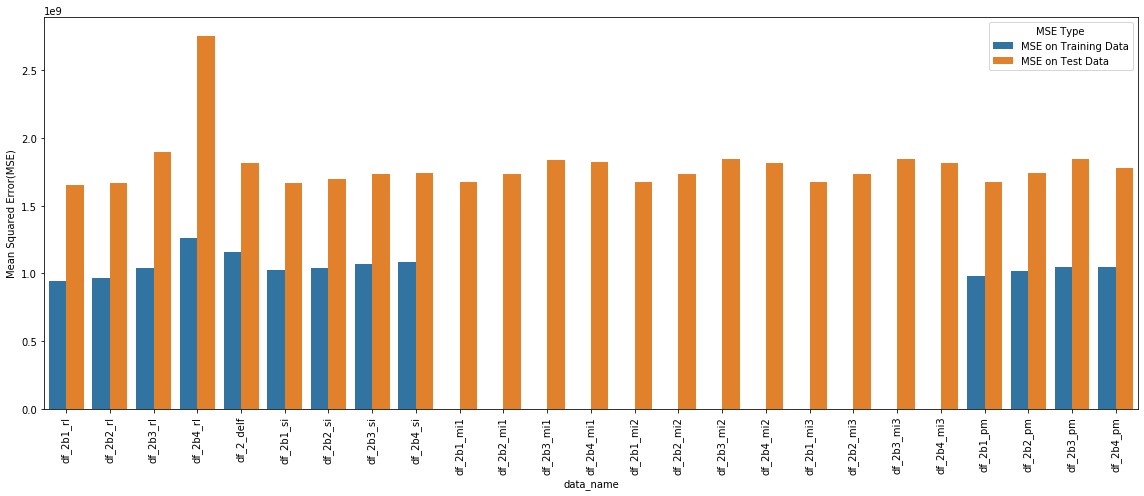

Train and Test MSEs for data sets in Part 2c


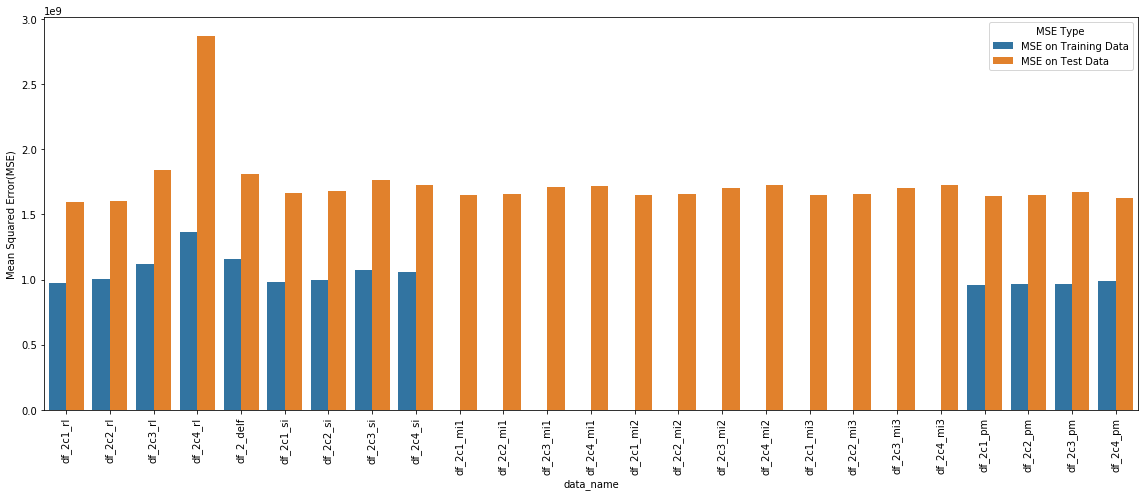

Train and Test MSEs for data sets in Part 3a


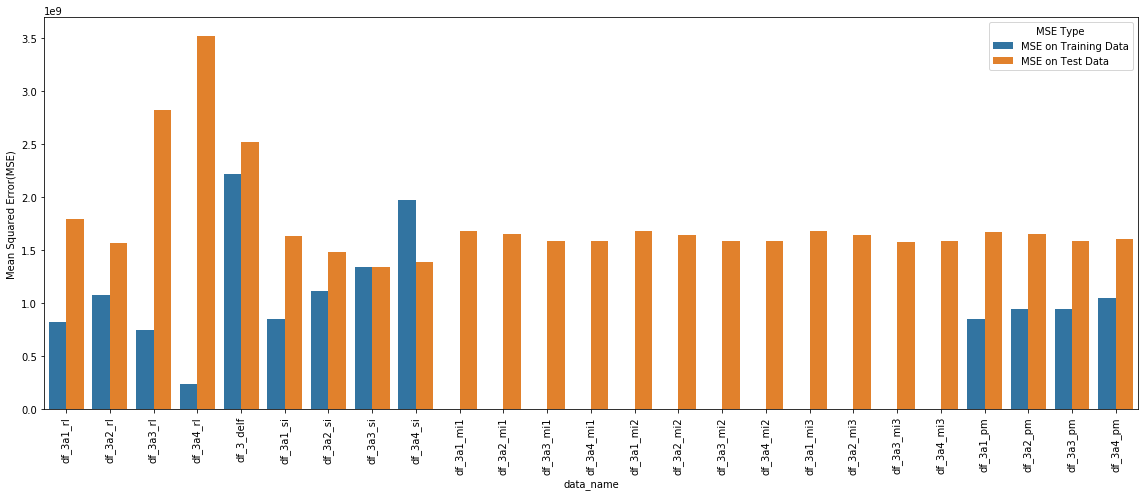

Train and Test MSEs for data sets in Part 3b


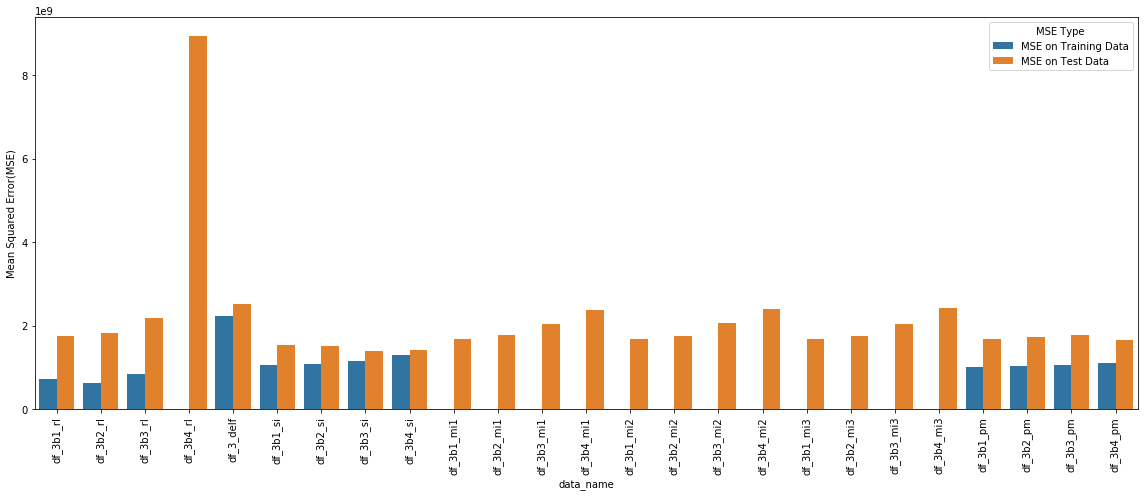

Train and Test MSEs for data sets in Part 3c


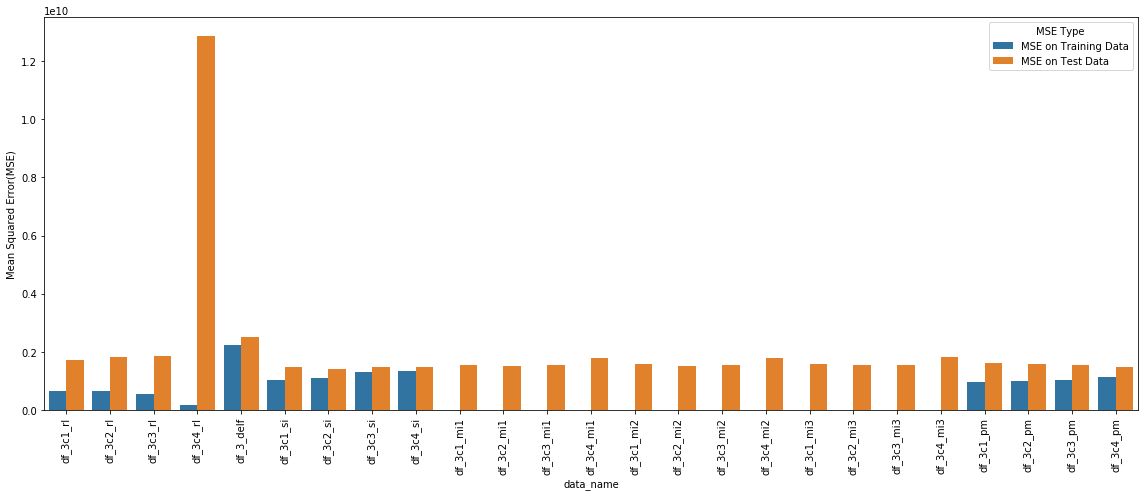

In [0]:
parts = ["2a","2b","2c","3a","3b","3c"]
for part in parts:
    print("Train and Test MSEs for data sets in Part", part)
    fig, ax = plt.subplots(figsize=(16,7))
    chart = sns.barplot(x="data_name", y="Mean Squared Error(MSE)", hue="MSE Type",
                      data=summary_table[summary_table["Part"]==("Part "+part)])
    for item in chart.get_xticklabels():
        item.set_rotation(90)
        item.horizontalalignment='right'
    fig.tight_layout()
    plt.show()

Part 2a;
- df_2_delf (delete feature) provides worst test MSE score, others have eqaully good MSE scores.

Part 2b; 
- df_2b4_rl (MAR mechanism, when missing percentage 50% , method is row-listwise),  provides worst test MSE score, others have eqaully good MSE scores.

Part 2c;
- df_2c4_rl (MNAR mechanism, when missing percentage 50% , method is row-listwise),  provides worst test MSE score, others have eqaully good MSE scores.

Part 3a;

- df_3a4_rl (MCAR mechanism, when missing percentage 50%, method is row-listwise),  provides worst test MSE score and the the lowest MSE score is achieved with df_3a3_si (MCAR mechanism when missing percentage 25%, and method is single imputation).

Part 3b;
- df_3b4_rl (MAR mechanism, when missing percentage 50%, method is row-listwise),  provides worst test MSE score and the the lowest MSE score is achieved with df_3b3_si (MAR mechanism when missing percentage 25%, and method is single imputation).

Part 3c;
- df_3c4_rl (MNAR mechanism, when missing percentage 50%, method is row-listwise),  others have eqaully good MSE scores.

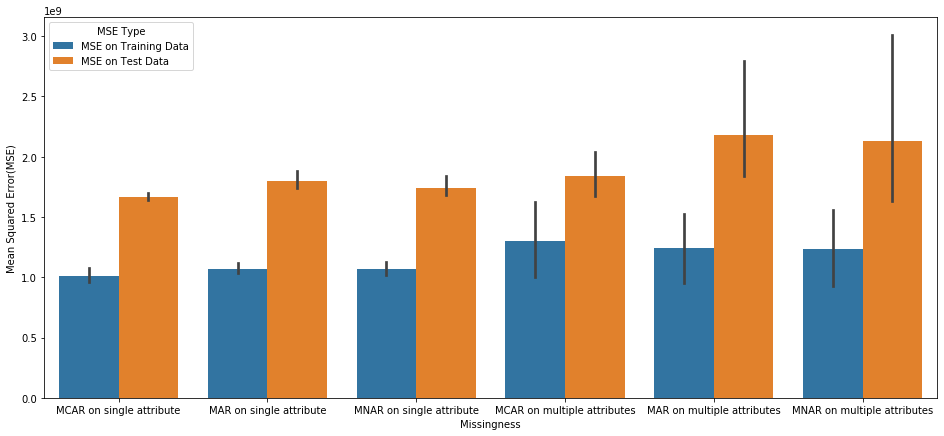

In [0]:
fig, ax = plt.subplots(figsize=(16,7))
chart = sns.barplot(x="Missingness", y="Mean Squared Error(MSE)", hue="MSE Type",
                      data=summary_table)

- MNAR MSE scores are higher than the MAR and MCAR on multiple attributes(Q3), it is expected because in MNAR mechanism, missing value is created dependent on itself, so it is hard to predict this type of missing data. 
- MCAR MSE scores are lower than the MAR MSE scores. A value which is created with MCAR mechanism can be easily predict by the model because in MCAR mechanism, missign value is  created randomly. Especially  for the MNAR data, method selection is also important, MSE scores vary depent on the selected method.

In [0]:
summary_table["Missingness Handling Method"]

0                rows listwise
1                rows listwise
2               delete feature
3               delete feature
4            single imputation
                ...           
331             delete feature
332          single imputation
333          single imputation
334    multiple imputation(10)
335    multiple imputation(10)
Name: Missingness Handling Method, Length: 336, dtype: object

In [0]:
summary_table[ (summary_table["Missingness Percentage"]=="25%") ].head(3)

,Missingness Percentage,Question #,Part,Missingness,Attribute,Missingness Mechanism,Missingness Handling Method,data_name,MSE Type,Mean Squared Error(MSE)
4,25%,Question 2,Part 2a,MCAR on single attribute,single attribute,MCAR,rows listwise,df_2a3_rl,MSE on Training Data,1.01e+09
5,25%,Question 2,Part 2a,MCAR on single attribute,single attribute,MCAR,rows listwise,df_2a3_rl,MSE on Test Data,1.62e+09
12,25%,Question 2,Part 2a,MCAR on single attribute,single attribute,MCAR,delete feature,df_2_delf,MSE on Training Data,1.16e+09


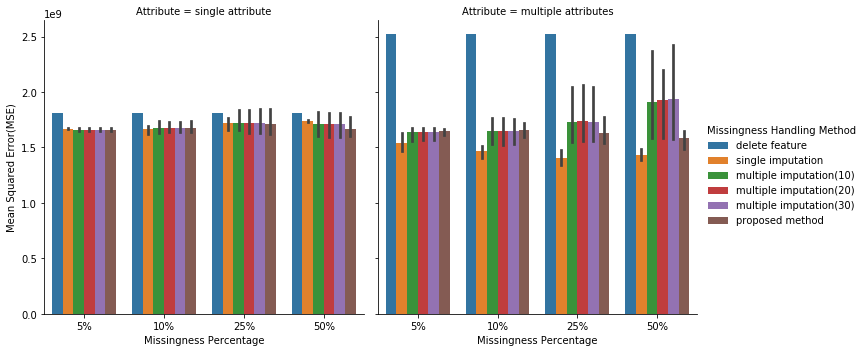

In [0]:
chart = sns.catplot(x="Missingness Percentage", y="Mean Squared Error(MSE)", hue="Missingness Handling Method", 
                    col="Attribute", kind="bar",
                      data=summary_table[ (summary_table["MSE Type"]=="MSE on Test Data") & (summary_table["Missingness Handling Method"]!="rows listwise")])
print("row listwise excluded(to better visualize others)")

- For the single attribute case(Q2), MSE scores of the delete feature method seems higher than the other methods. 
- For the multiple attribute case(Q3), this difference between delete feature and other methods can be seen more clear. As the missing percentage increase, method selection becomes more important. Single imputation provides better result as the missing percentage increase.

row listwise excluded(to better visualize others)


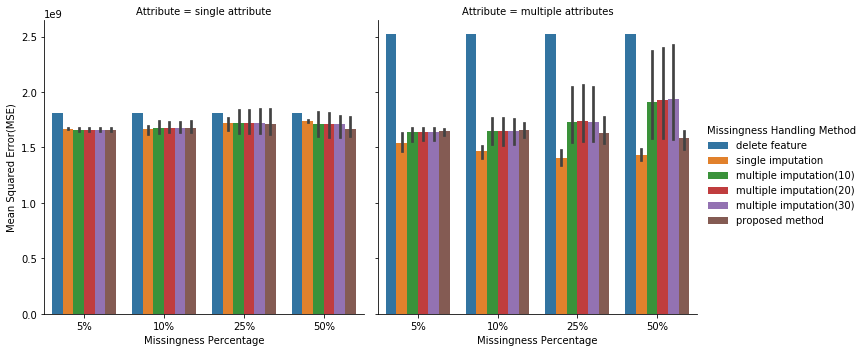

In [0]:
chart = sns.catplot(x="Missingness Percentage", y="Mean Squared Error(MSE)", hue="Missingness Handling Method", 
                    col="Attribute", kind="bar",
                      data=summary_table[ (summary_table["MSE Type"]=="MSE on Test Data") & (summary_table["Missingness Handling Method"]!="rows listwise")])
print("row listwise excluded(to better visualize others)")

- For the single attribute case(Q2), MSE scores of the delete feature method seems higher than the other methods. 
- For the multiple attribute case(Q3), this difference between delete feature and other methods can be seen more clear. As the missing percentage increase, method selection becomes more important. Single imputation provides better result as the missing percentage increase. Also, our proposed method provides less MSE score when compared to others(except single imputation).

Missingness Percentage: 50%


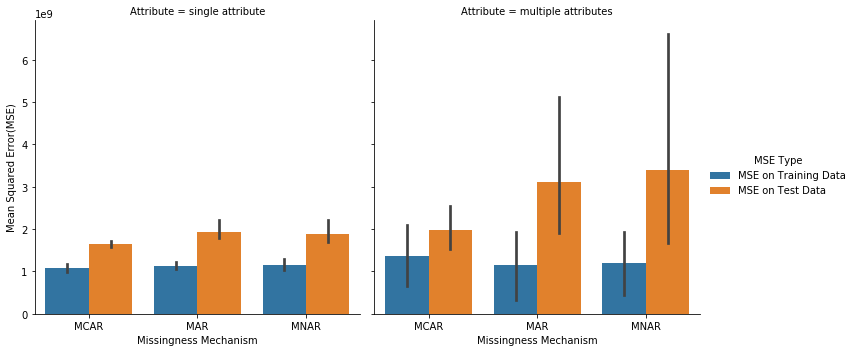

In [0]:
chart = sns.catplot(x="Missingness Mechanism", y="Mean Squared Error(MSE)", hue="MSE Type", 
                    col="Attribute", kind="bar",
                      data=summary_table[ summary_table["Missingness Percentage"]=="50%" ])
print("Missingness Percentage: 50%")

- MNAR MSE scores are higher than the MAR and MCAR on multiple attributes(Q3), it is expected because in MNAR mechanism, missing value is created dependent on itself, so it is hard to predict this type of missing data. 
- MCAR MSE scores are lower than the MAR MSE scores. A value which is created with MCAR mechanism can be easily predict by the model because in MCAR mechanism, missign value is  created randomly. Especially  for the MNAR data, method selection is also important, MSE scores vary depent on the selected method.

Missingness Percentage: 10%
MSE Type: MSE on Test Data


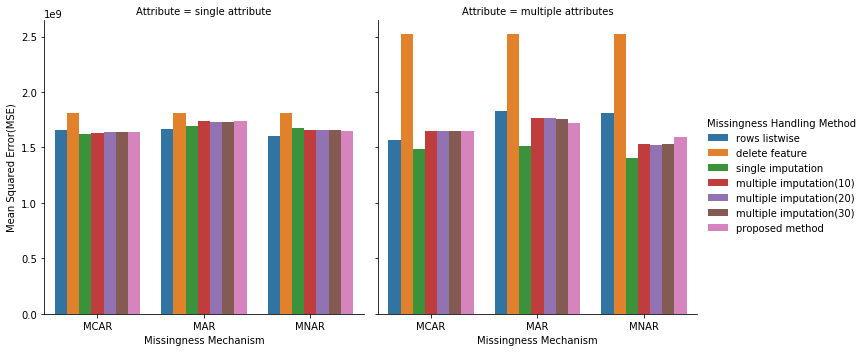

In [0]:
chart = sns.catplot(x="Missingness Mechanism", y="Mean Squared Error(MSE)", hue="Missingness Handling Method", 
                    col="Attribute", kind="bar",
                      data=summary_table[ (summary_table["Missingness Percentage"]=="10%") & (summary_table["MSE Type"]=="MSE on Test Data") ])
print("Missingness Percentage: 10%")
print("MSE Type: MSE on Test Data")

When missing percentage is 10%;
- For the single attribute, delete feature has higher MSE scores and the rest of the methods have nearly same MSE score. 
- For the multiple attribute, delete feature and rows-listwise MSE scores are the highest on the MNAR and MCAR. In general, single imputation provides better results. 

Missingness Percentage: 50%
MSE Type: MSE on Test Data


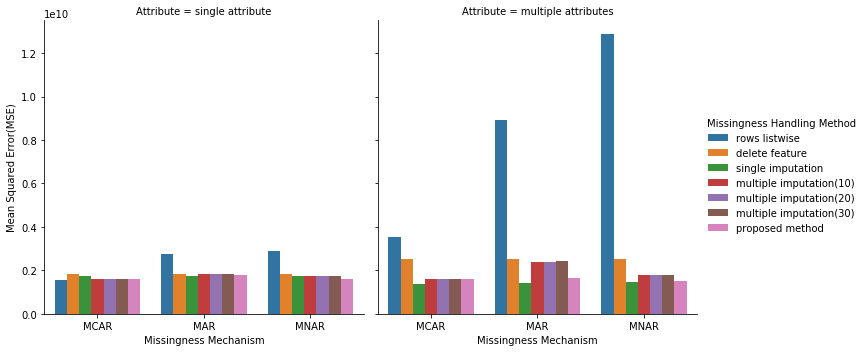

In [0]:
chart = sns.catplot(x="Missingness Mechanism", y="Mean Squared Error(MSE)", hue="Missingness Handling Method", 
                    col="Attribute", kind="bar",
                      data=summary_table[ (summary_table["Missingness Percentage"]=="50%") & (summary_table["MSE Type"]=="MSE on Test Data") ])
print("Missingness Percentage: 50%")
print("MSE Type: MSE on Test Data")

When missing percentage is 50%;
- For the single attribute, row-listwise has higher MSE scores and the rest of the methods have nearly same MSE score. 
- For the multiple attribute, rows-listwise MSE scores are increasing  from MCAR to MNAR. Delete feature also has higher MSE scores when compared to others. In general, single imputation provides better results.

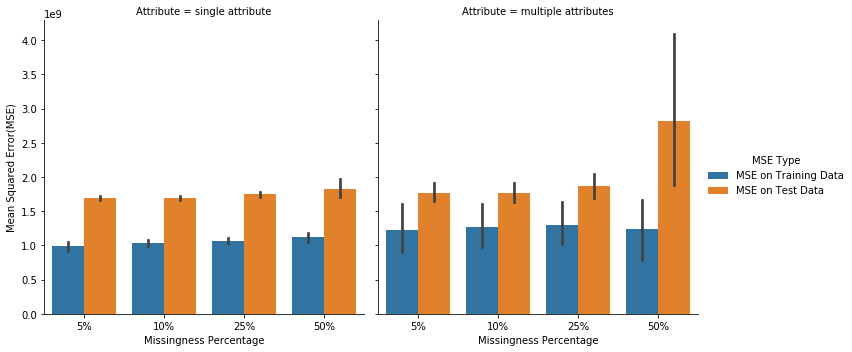

In [0]:
chart = sns.catplot(x="Missingness Percentage", y="Mean Squared Error(MSE)", hue="MSE Type", 
                    col="Attribute", kind="bar",
                      data=summary_table)

- For multiple attributes(Q3), as missigness percentage increasing, also MSE scores are increasing, because it is hard to predict with more missing data. Especially for the 50% missing data, MSE scores vary for the methods.

#### General Observations

- All train data errors are less than test errors, as it is expected.
- Row-listwise and delete featuremethod provides higher MSE scores in most of the cases, they perform worse than other methods.
- In general, single imputation perform well. 
- Our proposed method perform equally good with the other methods.
- If missingness mechanism is MNAR, errors are increasing because it is hard to making prediction about this type of missingness. MCAR type missing data can be predict more easily, and this leads to the lower errors.
- As missingess percent increase, MSE scores increase and  method selection is become more important, because MSE scores vary for the methods. 
- Especially for the MNAR mechanism, method selection is become more important because MSE scores vary for the methods. 

# Saving all created data frames (creation of csv files)

In [0]:
print("The number of dataframes produced so far: ", len(my_dfs))
save_only_these_files = [ x for x in my_dfs.keys() if len(x)<10 ] #exclude multiple imputation dfs
print("The number of dataframes (excluding multiple imputation dfs): ", len(save_only_these_files))

The number of dataframes produced so far:  1539
The number of dataframes (excluding multiple imputation dfs):  99


- Saving all can take time and memory depending on the computer resources you have! To save all but multiple imputation dfs,(99dfs-20MBsize-1minute?) run the cell below. To save all(1539dfs-467MBsize-about 10minutes?), uncomment the code line below.

In [0]:
%%time
save_under_this_folder_name = "Dfs_TermProject_PinarErdogan_AlpBayar_OguzHanoglu"
#save_only_these_files = "All"
save(my_dfs, folder_name = save_under_this_folder_name , file_list = save_only_these_files)

Saving to folder: 'Dfs_TermProject_PinarErdogan_AlpBayar_OguzHanoglu'
	99 out of 99 files (100%) are saved.
Wall time: 26.6 s
